# Deep cortical reinforcement learning: Policy gradients + Q-learning + GAN


In this notebook, we'll build a neural network that can learn to play games through reinforcement learning. More specifically, we'll use Q-learning to train an agent to play a game called [Cart-Pole](https://gym.openai.com/envs/CartPole-v0). In this game, a freely swinging pole is attached to a cart. The cart can move to the left and right, and the goal is to keep the pole upright as long as possible.

![Cart-Pole](assets/cart-pole.jpg)

We can simulate this game using [OpenAI Gym](https://gym.openai.com/). First, let's check out how OpenAI Gym works. Then, we'll get into training an agent to play the Cart-Pole game.

In [1]:
# In this one we should define and detect GPUs for tensorflow
# GPUs or CPU
import tensorflow as tf

# Check TensorFlow Version
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.7.1
Default GPU Device: 


>**Note:** Make sure you have OpenAI Gym cloned into the same directory with this notebook. I've included `gym` as a submodule, so you can run `git submodule --init --recursive` to pull the contents into the `gym` repo.

##### >**Note:** Make sure you have OpenAI Gym cloned. Then run this command `pip install -e gym/[all]`.

In [2]:
import gym

## Create the Cart-Pole game environment
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('MountainCarContinuous-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


We interact with the simulation through `env`. To show the simulation running, you can use `env.render()` to render one frame. Passing in an action as an integer to `env.step` will generate the next step in the simulation.  You can see how many actions are possible from `env.action_space` and to get a random action you can use `env.action_space.sample()`. This is general to all Gym games. In the Cart-Pole game, there are two possible actions, moving the cart left or right. So there are two actions we can take, encoded as 0 and 1.

Run the code below to watch the simulation run.

In [3]:
env.reset()
batch = []
for _ in range(1111):
    #env.render()
    action = env.action_space.sample()
    state, reward, done, info = env.step(action) # take a random action
    batch.append([action, state, reward, done, info])
    #print('state, action, reward, done, info:', state, action, reward, done, info)
    if done:
        env.reset()

To shut the window showing the simulation, use `env.close()`.

In [4]:
# env.close()

If you ran the simulation above, we can look at the rewards:

In [5]:
batch[0], 
batch[0][1].shape, state.shape

((4,), (4,))

In [6]:
import numpy as np
actions = np.array([each[0] for each in batch])
states = np.array([each[1] for each in batch])
rewards = np.array([each[2] for each in batch])
dones = np.array([each[3] for each in batch])
infos = np.array([each[4] for each in batch])

In [7]:
# print(rewards[-20:])
print('shapes:', np.array(rewards).shape, np.array(states).shape, np.array(actions).shape, np.array(dones).shape)
print('dtypes:', np.array(rewards).dtype, np.array(states).dtype, np.array(actions).dtype, np.array(dones).dtype)
print('states:', np.max(np.array(states)), np.min(np.array(states)))
print('actions:', np.max(np.array(actions)), np.min(np.array(actions)))
# print((np.max(np.array(actions)) - np.min(np.array(actions)))+1)
print('rewards:', np.max(np.array(rewards)), np.min(np.array(rewards)))

shapes: (1111,) (1111, 4) (1111,) (1111,)
dtypes: float64 float64 int64 bool
states: 2.59469811739118 -2.5474058812013642
actions: 1 0
rewards: 1.0 1.0


In [8]:
actions[:10]

array([0, 1, 1, 0, 1, 1, 1, 1, 1, 1])

In [9]:
rewards[:10]

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [10]:
# import numpy as np
def sigmoid(x, derivative=False):
  return x*(1-x) if derivative else 1/(1+np.exp(-x))

In [11]:
sigmoid(np.max(np.array(rewards))), sigmoid(np.min(np.array(rewards)))

(0.7310585786300049, 0.7310585786300049)

In [12]:
print('rewards:', np.max(np.array(rewards))/100, np.min(np.array(rewards))/100)

rewards: 0.01 0.01


The game resets after the pole has fallen past a certain angle. For each frame while the simulation is running, it returns a reward of 1.0. The longer the game runs, the more reward we get. Then, our network's goal is to maximize the reward by keeping the pole vertical. It will do this by moving the cart to the left and the right.

## Q-Network

We train our Q-learning agent using the Bellman Equation:

$$
Q(s, a) = r + \gamma \max{Q(s', a')}
$$

where $s$ is a state, $a$ is an action, and $s'$ is the next state from state $s$ and action $a$.

Before we used this equation to learn values for a Q-_table_. However, for this game there are a huge number of states available. The state has four values: the position and velocity of the cart, and the position and velocity of the pole. These are all real-valued numbers, so ignoring floating point precisions, you practically have infinite states. Instead of using a table then, we'll replace it with a neural network that will approximate the Q-table lookup function.

<img src="assets/deep-q-learning.png" width=450px>

Now, our Q value, $Q(s, a)$ is calculated by passing in a state to the network. The output will be Q-values for each available action, with fully connected hidden layers.

<img src="assets/q-network.png" width=550px>


As I showed before, we can define our targets for training as $\hat{Q}(s,a) = r + \gamma \max{Q(s', a')}$. Then we update the weights by minimizing $(\hat{Q}(s,a) - Q(s,a))^2$. 

For this Cart-Pole game, we have four inputs, one for each value in the state, and two outputs, one for each action. To get $\hat{Q}$, we'll first choose an action, then simulate the game using that action. This will get us the next state, $s'$, and the reward. With that, we can calculate $\hat{Q}$ then pass it back into the $Q$ network to run the optimizer and update the weights.

Below is my implementation of the Q-network. I used two fully connected layers with ReLU activations. Two seems to be good enough, three might be better. Feel free to try it out.

In [13]:
# Data of the model
def model_input(state_size):
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    actions = tf.placeholder(tf.int32, [None], name='actions')
    targetQs = tf.placeholder(tf.float32, [None], name='targetQs')
    reward = tf.placeholder(tf.float32, [], name='reward')
    return states, actions, targetQs, reward

In [14]:
# How to use batch-norm
#   x_norm = tf.layers.batch_normalization(x, training=training)

#   # ...

#   update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
#   with tf.control_dependencies(update_ops):
#     train_op = optimizer.minimize(loss)

In [15]:
# training: Either a Python boolean, or a TensorFlow boolean scalar tensor (e.g. a placeholder). 
# Whether to return the output in: 
# training mode (normalized with statistics of the current batch) or 
# inference mode (normalized with moving statistics). 
# NOTE: make sure to set this parameter correctly, or else your training/inference will not work properly.

In [16]:
# Generator/Controller: Generating/prediting the actions
def generator(states, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=action_size)        
        #predictions = tf.nn.softmax(logits)

        # return actions logits
        return logits

In [17]:
# Discriminator/Dopamine: Reward function/planner/naviator/advisor/supervisor/cortical columns
def discriminator(states, actions, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('discriminator', reuse=reuse):
        # Fusion/merge states and actions/ SA/ SM
        x_fused = tf.concat(axis=1, values=[states, actions])
        
        # First fully connected layer
        h1 = tf.layers.dense(inputs=x_fused, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=1)        
        #predictions = tf.nn.softmax(logits)

        # return rewards logits
        return logits

In [18]:
def model_loss(action_size, hidden_size, states, actions, targetQs, reward):
    # G
    actions_logits = generator(states=states, hidden_size=hidden_size, action_size=action_size)
    actions_labels = tf.one_hot(indices=actions, depth=action_size, dtype=actions_logits.dtype)
    neg_log_prob_actions = tf.nn.softmax_cross_entropy_with_logits_v2(logits=actions_logits, 
                                                                      labels=actions_labels)
    rewards = reward * tf.ones_like(targetQs)
    #Qs_labels = targetQs[1:]
    Qs_labels = rewards[:-1] + (0.99*targetQs[1:])
    #Qs_labels = tf.concat(axis=0, values=[Qs_labels, tf.zeros([1])])
    #g_loss = tf.reduce_mean(neg_log_prob_actions * Qs_labels)
    g_loss = tf.reduce_mean(neg_log_prob_actions[:-1] * Qs_labels)
    
    # D
    Qs_logits = discriminator(actions=actions_logits, hidden_size=hidden_size, states=states)
    d_lossR = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=tf.reshape(Qs_logits, [-1]),
                                                                     labels=rewards))
    # d_lossQ = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=tf.reshape(Qs_logits, [-1]),
    #                                                                  labels=tf.nn.sigmoid(Qs_labels)))
    d_lossQ = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=tf.reshape(Qs_logits[:-1], [-1]),
                                                                     labels=tf.nn.sigmoid(Qs_labels)))
    d_loss = d_lossR #+ d_lossQ

    return actions_logits, Qs_logits, g_loss, d_loss, d_lossR, d_lossQ

In [19]:
# Optimizating/training/learning G & D
def model_opt(g_loss, d_loss, learning_rate):
    """
    Get optimization operations in order
    :param g_loss: Generator loss Tensor for action prediction
    :param d_loss: Discriminator loss Tensor for reward prediction for generated/prob/logits action
    :param learning_rate: Learning Rate Placeholder
    :return: A tuple of (qfunction training, generator training, discriminator training)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): # Required for batchnorm (BN)
        g_opt = tf.train.AdamOptimizer(learning_rate).minimize(g_loss, var_list=g_vars)
        d_opt = tf.train.AdamOptimizer(learning_rate).minimize(d_loss, var_list=d_vars)

    return g_opt, d_opt

In [20]:
class Model:
    def __init__(self, state_size, action_size, hidden_size, learning_rate):

        # Data of the Model: make the data available inside the framework
        self.states, self.actions, self.targetQs, self.reward = model_input(state_size=state_size)

        # Create the Model: calculating the loss and forwad pass
        self.actions_logits, self.Qs_logits, self.g_loss, self.d_loss, self.d_lossR, self.d_lossQ = model_loss(
            action_size=action_size, hidden_size=hidden_size, # model init parameters
            states=self.states, actions=self.actions, # model input
            targetQs=self.targetQs, reward=self.reward) # model input
        
        # Update the model: backward pass and backprop
        self.g_opt, self.d_opt = model_opt(g_loss=self.g_loss, d_loss=self.d_loss, learning_rate=learning_rate)

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [21]:
print('state size:{}'.format(states.shape), 
      'actions:{}'.format(actions.shape)) 
print('action size:{}'.format(np.max(actions) - np.min(actions)+1))

state size:(1111, 4) actions:(1111,)
action size:2


In [22]:
# Training parameters
# Network parameters
state_size = 4               # number of units for the input state/observation -- simulation
action_size = 2              # number of units for the output actions -- simulation
hidden_size = 64             # number of units in each Q-network hidden layer -- simulation
learning_rate = 0.001          # learning rate for adam

In [23]:
# Reset/init the graph/session
graph = tf.reset_default_graph()

# Init the model
model = Model(action_size=action_size, hidden_size=hidden_size, state_size=state_size, learning_rate=learning_rate)

## Training the model

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [24]:
# import gym

# ## Create the Cart-Pole game environment
# env = gym.make('CartPole-v0')
# env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# # env = gym.make('MountainCar-v0')
# # env = gym.make('Pendulum-v0')
# # env = gym.make('Blackjack-v0')
# # env = gym.make('FrozenLake-v0')
# # env = gym.make('AirRaid-ram-v0')
# # env = gym.make('AirRaid-v0')
# # env = gym.make('BipedalWalker-v2')
# # env = gym.make('Copy-v0')
# # env = gym.make('CarRacing-v0')
# # env = gym.make('Ant-v2') #mujoco
# # env = gym.make('FetchPickAndPlace-v1') # mujoco required!

In [31]:
from collections import deque
episodes_total_reward = deque(maxlen=100) # 100 episodes average/running average/running mean/window
saver = tf.train.Saver()
rewards_list, g_loss_list, d_loss_list = [], [], []
rates_list, d_lossR_list, d_lossQ_list = [], [], []

# TF session for training
with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Training episodes/epochs
    for ep in range(111111):
        batch = [] # every data batch
        total_reward = 0
        state = env.reset() # env first state

        # Training steps/batches
        while True:
            action_logits, Q_logits = sess.run(fetches=[model.actions_logits, model.Qs_logits], 
                                               feed_dict={model.states: np.reshape(state, [1, -1])})
            action = np.argmax(action_logits)
            batch.append([state, action, Q_logits])
            state, reward, done, _ = env.step(action)
            total_reward += reward
            if done is True: # episode ended success/failure
                episodes_total_reward.append(total_reward) # stopping criteria
                rate = total_reward/ 500 # success is 500 points: 0-1
                break

        # Training using batches
        #batch = memory.buffer
        states = np.array([each[0] for each in batch])
        actions = np.array([each[1] for each in batch])
        targetQs = np.array([each[2] for each in batch])
        g_loss, d_loss, d_lossR, d_lossQ, _, _ = sess.run([model.g_loss, model.d_loss, 
                                                           model.d_lossR, model.d_lossQ, 
                                                           model.g_opt, model.d_opt],
                                                          feed_dict = {model.states: states, 
                                                                       model.actions: actions,
                                                                       model.reward: rate,
                                                                       model.targetQs: targetQs.reshape([-1])})
        # Average 100 episode total reward
        # Print out
        print('Episode:{}'.format(ep),
              'meanR:{:.4f}'.format(np.mean(episodes_total_reward)),
              'rate:{:.4f}'.format(rate),
              'gloss:{:.4f}'.format(g_loss),
              'dloss:{:.4f}'.format(d_loss),
              'dlossR:{:.4f}'.format(d_lossR),
              'dlossQ:{:.4f}'.format(d_lossQ))
        # Ploting out
        rewards_list.append([ep, np.mean(episodes_total_reward)])
        rates_list.append([ep, rate])
        g_loss_list.append([ep, g_loss])
        d_loss_list.append([ep, d_loss])
        d_lossR_list.append([ep, d_lossR])
        d_lossQ_list.append([ep, d_lossQ])
        # Break episode/epoch loop
        if np.mean(episodes_total_reward) >= 500:
            break
            
    # At the end of all training episodes/epochs
    saver.save(sess, 'checkpoints/modelR2.ckpt')

Episode:0 meanR:21.0000 rate:0.0420 gloss:-0.0119 dloss:0.6660 dlossR:0.6660 dlossQ:0.6923
Episode:1 meanR:32.0000 rate:0.0860 gloss:-0.0199 dloss:0.6484 dlossR:0.6484 dlossQ:0.6917
Episode:2 meanR:32.6667 rate:0.0680 gloss:-0.0152 dloss:0.6554 dlossR:0.6554 dlossQ:0.6935
Episode:3 meanR:31.7500 rate:0.0580 gloss:-0.0300 dloss:0.6493 dlossR:0.6493 dlossQ:0.6932
Episode:4 meanR:33.4000 rate:0.0800 gloss:-0.0201 dloss:0.6484 dlossR:0.6484 dlossQ:0.6938
Episode:5 meanR:36.1667 rate:0.1000 gloss:-0.0276 dloss:0.6387 dlossR:0.6387 dlossQ:0.6942
Episode:6 meanR:36.7143 rate:0.0800 gloss:-0.0649 dloss:0.6222 dlossR:0.6222 dlossQ:0.6929
Episode:7 meanR:38.8750 rate:0.1080 gloss:-0.0623 dloss:0.6186 dlossR:0.6186 dlossQ:0.6937
Episode:8 meanR:39.0000 rate:0.0800 gloss:-0.1085 dloss:0.5984 dlossR:0.5984 dlossQ:0.6910
Episode:9 meanR:38.0000 rate:0.0580 gloss:-0.1599 dloss:0.5729 dlossR:0.5729 dlossQ:0.6869
Episode:10 meanR:39.4545 rate:0.1080 gloss:-0.1259 dloss:0.5879 dlossR:0.5879 dlossQ:0.691

Episode:93 meanR:44.3298 rate:0.1000 gloss:-1.6155 dloss:0.3332 dlossR:0.3332 dlossQ:0.3068
Episode:94 meanR:44.2105 rate:0.0660 gloss:-1.6919 dloss:0.2453 dlossR:0.2453 dlossQ:0.2811
Episode:95 meanR:44.2917 rate:0.1040 gloss:-1.6090 dloss:0.3413 dlossR:0.3413 dlossQ:0.3050
Episode:96 meanR:44.2577 rate:0.0820 gloss:-1.6613 dloss:0.2859 dlossR:0.2859 dlossQ:0.2893
Episode:97 meanR:44.1735 rate:0.0720 gloss:-1.6825 dloss:0.2607 dlossR:0.2607 dlossQ:0.2838
Episode:98 meanR:43.8182 rate:0.0180 gloss:-2.4800 dloss:0.1090 dlossR:0.1090 dlossQ:0.1513
Episode:99 meanR:43.6900 rate:0.0620 gloss:-1.6056 dloss:0.2361 dlossR:0.2361 dlossQ:0.3015
Episode:100 meanR:43.8600 rate:0.0760 gloss:-1.6046 dloss:0.2698 dlossR:0.2698 dlossQ:0.3015
Episode:101 meanR:43.8500 rate:0.0840 gloss:-1.6290 dloss:0.2895 dlossR:0.2895 dlossQ:0.2948
Episode:102 meanR:44.2600 rate:0.1500 gloss:-1.5472 dloss:0.4490 dlossR:0.4490 dlossQ:0.3175
Episode:103 meanR:46.6100 rate:0.5280 gloss:-1.2013 dloss:1.3135 dlossR:1.313

Episode:185 meanR:56.3400 rate:0.0800 gloss:-1.2549 dloss:0.2934 dlossR:0.2934 dlossQ:0.4105
Episode:186 meanR:56.4200 rate:0.0500 gloss:-1.2732 dloss:0.2367 dlossR:0.2367 dlossQ:0.4042
Episode:187 meanR:56.4600 rate:0.0420 gloss:-1.4559 dloss:0.2031 dlossR:0.2031 dlossQ:0.3496
Episode:188 meanR:56.2900 rate:0.0200 gloss:-2.2360 dloss:0.1327 dlossR:0.1327 dlossQ:0.2004
Episode:189 meanR:56.3400 rate:0.0320 gloss:-1.4048 dloss:0.1891 dlossR:0.1891 dlossQ:0.3655
Episode:190 meanR:56.2000 rate:0.0420 gloss:-1.3360 dloss:0.2150 dlossR:0.2150 dlossQ:0.3865
Episode:191 meanR:56.2800 rate:0.0520 gloss:-1.3605 dloss:0.2319 dlossR:0.2319 dlossQ:0.3790
Episode:192 meanR:56.0400 rate:0.0480 gloss:-1.2951 dloss:0.2296 dlossR:0.2296 dlossQ:0.3977
Episode:193 meanR:55.7600 rate:0.0440 gloss:-1.2524 dloss:0.2275 dlossR:0.2275 dlossQ:0.4107
Episode:194 meanR:55.8400 rate:0.0820 gloss:-1.2798 dloss:0.2944 dlossR:0.2944 dlossQ:0.4015
Episode:195 meanR:55.6900 rate:0.0740 gloss:-1.2755 dloss:0.2797 dloss

Episode:283 meanR:55.1300 rate:0.0760 gloss:-0.9205 dloss:0.3269 dlossR:0.3269 dlossQ:0.5189
Episode:284 meanR:55.1600 rate:0.1000 gloss:-1.1607 dloss:0.3672 dlossR:0.3672 dlossQ:0.4508
Episode:285 meanR:55.1600 rate:0.0800 gloss:-1.3121 dloss:0.3179 dlossR:0.3179 dlossQ:0.4075
Episode:286 meanR:55.5000 rate:0.1180 gloss:-1.1807 dloss:0.3972 dlossR:0.3972 dlossQ:0.4463
Episode:287 meanR:55.9800 rate:0.1380 gloss:-1.2011 dloss:0.4235 dlossR:0.4235 dlossQ:0.4367
Episode:288 meanR:56.4600 rate:0.1160 gloss:-1.3589 dloss:0.3784 dlossR:0.3784 dlossQ:0.3880
Episode:289 meanR:58.8700 rate:0.5140 gloss:-0.8925 dloss:1.1110 dlossR:1.1110 dlossQ:0.5507
Episode:290 meanR:59.2600 rate:0.1200 gloss:-1.3402 dloss:0.3871 dlossR:0.3871 dlossQ:0.3951
Episode:291 meanR:59.6500 rate:0.1300 gloss:-1.3969 dloss:0.4069 dlossR:0.4069 dlossQ:0.3744
Episode:292 meanR:60.0600 rate:0.1300 gloss:-1.3382 dloss:0.4035 dlossR:0.4035 dlossQ:0.3930
Episode:293 meanR:60.5800 rate:0.1480 gloss:-1.3098 dloss:0.4413 dloss

Episode:372 meanR:70.6100 rate:0.8460 gloss:-0.8071 dloss:1.8477 dlossR:1.8477 dlossQ:0.6090
Episode:373 meanR:71.0100 rate:0.1140 gloss:-1.5890 dloss:0.3857 dlossR:0.3857 dlossQ:0.3357
Episode:374 meanR:71.1500 rate:0.0580 gloss:-1.2272 dloss:0.2557 dlossR:0.2557 dlossQ:0.4195
Episode:375 meanR:71.1300 rate:0.0320 gloss:-1.3944 dloss:0.1898 dlossR:0.1898 dlossQ:0.3690
Episode:376 meanR:71.1300 rate:0.0340 gloss:-1.5692 dloss:0.1773 dlossR:0.1773 dlossQ:0.3176
Episode:377 meanR:71.1200 rate:0.0260 gloss:-1.5874 dloss:0.1600 dlossR:0.1600 dlossQ:0.3131
Episode:378 meanR:71.1300 rate:0.0300 gloss:-1.5723 dloss:0.1691 dlossR:0.1691 dlossQ:0.3171
Episode:379 meanR:71.1400 rate:0.0280 gloss:-1.7639 dloss:0.1537 dlossR:0.1537 dlossQ:0.2679
Episode:380 meanR:71.2000 rate:0.0320 gloss:-1.6971 dloss:0.1665 dlossR:0.1665 dlossQ:0.2859
Episode:381 meanR:71.7600 rate:0.1300 gloss:-1.5624 dloss:0.4223 dlossR:0.4223 dlossQ:0.3416
Episode:382 meanR:72.6800 rate:0.2120 gloss:-1.3258 dloss:0.5743 dloss

Episode:465 meanR:59.9200 rate:0.2440 gloss:-1.2443 dloss:0.6258 dlossR:0.6258 dlossQ:0.4172
Episode:466 meanR:60.5400 rate:0.1500 gloss:-1.3388 dloss:0.4338 dlossR:0.4338 dlossQ:0.3855
Episode:467 meanR:61.1500 rate:0.1460 gloss:-1.3661 dloss:0.4287 dlossR:0.4287 dlossQ:0.3790
Episode:468 meanR:61.0900 rate:0.0220 gloss:-2.9904 dloss:0.1321 dlossR:0.1321 dlossQ:0.1156
Episode:469 meanR:62.0200 rate:0.2180 gloss:-1.2575 dloss:0.5709 dlossR:0.5709 dlossQ:0.4115
Episode:470 meanR:63.9000 rate:0.4040 gloss:-1.0566 dloss:0.9249 dlossR:0.9249 dlossQ:0.4856
Episode:471 meanR:63.5000 rate:0.0320 gloss:-1.9053 dloss:0.1553 dlossR:0.1553 dlossQ:0.2358
Episode:472 meanR:59.4500 rate:0.0360 gloss:-1.8431 dloss:0.1687 dlossR:0.1687 dlossQ:0.2514
Episode:473 meanR:59.0300 rate:0.0300 gloss:-1.9184 dloss:0.1507 dlossR:0.1507 dlossQ:0.2345
Episode:474 meanR:58.9100 rate:0.0340 gloss:-1.9028 dloss:0.1614 dlossR:0.1614 dlossQ:0.2380
Episode:475 meanR:59.2200 rate:0.0940 gloss:-1.3813 dloss:0.3264 dloss

Episode:554 meanR:120.5100 rate:0.2120 gloss:-0.4233 dloss:0.5411 dlossR:0.5411 dlossQ:0.6535
Episode:555 meanR:121.3700 rate:0.2300 gloss:-0.4223 dloss:0.5565 dlossR:0.5565 dlossQ:0.6531
Episode:556 meanR:122.1700 rate:0.2040 gloss:-0.5080 dloss:0.5275 dlossR:0.5275 dlossQ:0.6323
Episode:557 meanR:122.8800 rate:0.1820 gloss:-0.5658 dloss:0.5008 dlossR:0.5008 dlossQ:0.6180
Episode:558 meanR:123.6100 rate:0.1800 gloss:-0.6047 dloss:0.4951 dlossR:0.4951 dlossQ:0.6079
Episode:559 meanR:123.5800 rate:0.0220 gloss:-0.9749 dloss:0.2855 dlossR:0.2855 dlossQ:0.4939
Episode:560 meanR:124.3900 rate:0.2000 gloss:-0.5928 dloss:0.5181 dlossR:0.5181 dlossQ:0.6101
Episode:561 meanR:125.4500 rate:0.2480 gloss:-0.6166 dloss:0.5698 dlossR:0.5698 dlossQ:0.6056
Episode:562 meanR:126.5700 rate:0.2740 gloss:-0.6026 dloss:0.6034 dlossR:0.6034 dlossQ:0.6082
Episode:563 meanR:127.8000 rate:0.2960 gloss:-0.4237 dloss:0.6206 dlossR:0.6206 dlossQ:0.6507
Episode:564 meanR:127.9100 rate:0.3020 gloss:-0.4239 dloss:0

Episode:642 meanR:329.0300 rate:0.4360 gloss:1.1198 dloss:1.0237 dlossR:1.0237 dlossQ:0.4319
Episode:643 meanR:330.5400 rate:0.5280 gloss:1.2756 dloss:0.9450 dlossR:0.9450 dlossQ:0.3831
Episode:644 meanR:331.5500 rate:0.4320 gloss:1.0965 dloss:1.0307 dlossR:1.0307 dlossQ:0.4337
Episode:645 meanR:332.3100 rate:0.4020 gloss:0.9567 dloss:0.9961 dlossR:0.9961 dlossQ:0.4761
Episode:646 meanR:333.9400 rate:0.5800 gloss:1.1449 dloss:0.8179 dlossR:0.8179 dlossQ:0.4218
Episode:647 meanR:334.4200 rate:0.3200 gloss:2.0235 dloss:2.1218 dlossR:2.1218 dlossQ:0.2151
Episode:648 meanR:336.4700 rate:0.6560 gloss:1.0989 dloss:0.6980 dlossR:0.6980 dlossQ:0.4395
Episode:649 meanR:338.7400 rate:0.7000 gloss:0.9354 dloss:0.6263 dlossR:0.6263 dlossQ:0.5067
Episode:650 meanR:339.3300 rate:0.3360 gloss:1.7573 dloss:1.8386 dlossR:1.8386 dlossQ:0.2404
Episode:651 meanR:339.5500 rate:0.2600 gloss:0.4778 dloss:0.8822 dlossR:0.8822 dlossQ:0.6149
Episode:652 meanR:341.6800 rate:0.6580 gloss:0.8984 dloss:0.6669 dloss

Episode:730 meanR:231.5800 rate:0.8440 gloss:0.2659 dloss:0.7746 dlossR:0.7746 dlossQ:0.7311
Episode:731 meanR:229.4000 rate:0.5640 gloss:0.1802 dloss:0.7048 dlossR:0.7048 dlossQ:0.7099
Episode:732 meanR:231.5800 rate:0.6400 gloss:0.1959 dloss:0.7226 dlossR:0.7226 dlossQ:0.7155
Episode:733 meanR:234.1400 rate:0.8060 gloss:0.2928 dloss:0.7258 dlossR:0.7258 dlossQ:0.7121
Episode:734 meanR:234.8400 rate:0.8520 gloss:0.3192 dloss:0.7235 dlossR:0.7235 dlossQ:0.7096
Episode:735 meanR:234.7500 rate:0.9820 gloss:0.3677 dloss:0.7356 dlossR:0.7356 dlossQ:0.7125
Episode:736 meanR:235.7800 rate:1.0000 gloss:0.3848 dloss:0.7146 dlossR:0.7146 dlossQ:0.7024
Episode:737 meanR:235.3300 rate:0.7040 gloss:0.2711 dloss:0.7013 dlossR:0.7013 dlossQ:0.6980
Episode:738 meanR:232.8600 rate:0.5060 gloss:0.1876 dloss:0.6945 dlossR:0.6945 dlossQ:0.6971
Episode:739 meanR:233.5700 rate:0.5680 gloss:0.2246 dloss:0.6937 dlossR:0.6937 dlossQ:0.6905
Episode:740 meanR:233.4000 rate:0.8820 gloss:0.3580 dloss:0.6884 dloss

Episode:818 meanR:250.1800 rate:1.0000 gloss:0.1385 dloss:0.8733 dlossR:0.8733 dlossQ:0.7717
Episode:819 meanR:251.4800 rate:1.0000 gloss:0.1533 dloss:0.8436 dlossR:0.8436 dlossQ:0.7610
Episode:820 meanR:253.2500 rate:1.0000 gloss:0.1671 dloss:0.8177 dlossR:0.8177 dlossQ:0.7514
Episode:821 meanR:255.9100 rate:1.0000 gloss:0.1760 dloss:0.7973 dlossR:0.7973 dlossQ:0.7425
Episode:822 meanR:258.5800 rate:1.0000 gloss:0.1793 dloss:0.7810 dlossR:0.7810 dlossQ:0.7347
Episode:823 meanR:260.2500 rate:1.0000 gloss:0.1879 dloss:0.7637 dlossR:0.7637 dlossQ:0.7285
Episode:824 meanR:261.6200 rate:1.0000 gloss:0.1903 dloss:0.7530 dlossR:0.7530 dlossQ:0.7225
Episode:825 meanR:263.5900 rate:1.0000 gloss:0.1910 dloss:0.7418 dlossR:0.7418 dlossQ:0.7177
Episode:826 meanR:264.5200 rate:1.0000 gloss:0.1954 dloss:0.7338 dlossR:0.7338 dlossQ:0.7134
Episode:827 meanR:265.6600 rate:1.0000 gloss:0.1942 dloss:0.7259 dlossR:0.7259 dlossQ:0.7102
Episode:828 meanR:268.2800 rate:1.0000 gloss:0.1911 dloss:0.7122 dloss

Episode:906 meanR:233.7300 rate:0.3920 gloss:0.0648 dloss:0.7147 dlossR:0.7147 dlossQ:0.6855
Episode:907 meanR:232.6800 rate:0.1520 gloss:-0.0047 dloss:0.6722 dlossR:0.6722 dlossQ:0.7027
Episode:908 meanR:232.1300 rate:0.3900 gloss:0.0510 dloss:0.7052 dlossR:0.7052 dlossQ:0.6961
Episode:909 meanR:232.4400 rate:0.3880 gloss:0.0436 dloss:0.7036 dlossR:0.7036 dlossQ:0.6974
Episode:910 meanR:230.9200 rate:0.1660 gloss:-0.0090 dloss:0.6614 dlossR:0.6614 dlossQ:0.7054
Episode:911 meanR:229.8700 rate:0.3820 gloss:0.0296 dloss:0.6972 dlossR:0.6972 dlossQ:0.7066
Episode:912 meanR:226.2900 rate:0.2840 gloss:0.0141 dloss:0.6943 dlossR:0.6943 dlossQ:0.7054
Episode:913 meanR:223.1700 rate:0.3760 gloss:0.0179 dloss:0.6907 dlossR:0.6907 dlossQ:0.7107
Episode:914 meanR:220.1500 rate:0.3960 gloss:0.0204 dloss:0.6912 dlossR:0.6912 dlossQ:0.7139
Episode:915 meanR:217.0500 rate:0.3800 gloss:0.0103 dloss:0.6871 dlossR:0.6871 dlossQ:0.7173
Episode:916 meanR:213.4400 rate:0.2780 gloss:-0.0110 dloss:0.6735 dl

Episode:995 meanR:238.5100 rate:0.1380 gloss:-0.0075 dloss:0.6448 dlossR:0.6448 dlossQ:0.6985
Episode:996 meanR:238.3900 rate:0.1440 gloss:-0.0157 dloss:0.6406 dlossR:0.6406 dlossQ:0.6980
Episode:997 meanR:238.3000 rate:0.1460 gloss:-0.0163 dloss:0.6381 dlossR:0.6381 dlossQ:0.6982
Episode:998 meanR:238.1900 rate:0.1460 gloss:-0.0033 dloss:0.6397 dlossR:0.6397 dlossQ:0.6974
Episode:999 meanR:238.1300 rate:0.1460 gloss:-0.0012 dloss:0.6416 dlossR:0.6416 dlossQ:0.6986
Episode:1000 meanR:237.9400 rate:0.1340 gloss:-0.0118 dloss:0.6224 dlossR:0.6224 dlossQ:0.6967
Episode:1001 meanR:237.8600 rate:0.1420 gloss:-0.0165 dloss:0.6163 dlossR:0.6163 dlossQ:0.6984
Episode:1002 meanR:237.7700 rate:0.1440 gloss:-0.0251 dloss:0.6136 dlossR:0.6136 dlossQ:0.6964
Episode:1003 meanR:237.6200 rate:0.1380 gloss:-0.0251 dloss:0.6054 dlossR:0.6054 dlossQ:0.6950
Episode:1004 meanR:236.9300 rate:0.1440 gloss:-0.0156 dloss:0.6078 dlossR:0.6078 dlossQ:0.6984
Episode:1005 meanR:236.8000 rate:0.1440 gloss:-0.0174 d

Episode:1083 meanR:348.7600 rate:0.8460 gloss:0.1996 dloss:0.4570 dlossR:0.4570 dlossQ:0.2911
Episode:1084 meanR:351.0100 rate:0.6020 gloss:0.2242 dloss:0.9078 dlossR:0.9078 dlossQ:0.3670
Episode:1085 meanR:353.1400 rate:0.5740 gloss:0.2173 dloss:0.9479 dlossR:0.9479 dlossQ:0.3789
Episode:1086 meanR:354.7100 rate:0.4760 gloss:0.1812 dloss:1.1265 dlossR:1.1265 dlossQ:0.3750
Episode:1087 meanR:356.3200 rate:0.4660 gloss:0.1808 dloss:1.1170 dlossR:1.1170 dlossQ:0.3866
Episode:1088 meanR:358.5000 rate:0.5740 gloss:0.1281 dloss:0.8801 dlossR:0.8801 dlossQ:0.3961
Episode:1089 meanR:359.7000 rate:0.3800 gloss:0.1476 dloss:1.1327 dlossR:1.1327 dlossQ:0.4546
Episode:1090 meanR:361.8900 rate:0.4920 gloss:0.1391 dloss:0.9786 dlossR:0.9786 dlossQ:0.4137
Episode:1091 meanR:363.4800 rate:0.4620 gloss:0.1337 dloss:0.9821 dlossR:0.9821 dlossQ:0.4429
Episode:1092 meanR:364.5600 rate:0.3580 gloss:0.1077 dloss:1.0241 dlossR:1.0241 dlossQ:0.5086
Episode:1093 meanR:365.6500 rate:0.3680 gloss:0.1244 dloss:0

Episode:1171 meanR:235.5100 rate:0.4240 gloss:0.0124 dloss:0.6921 dlossR:0.6921 dlossQ:0.7004
Episode:1172 meanR:232.5800 rate:0.4140 gloss:0.0137 dloss:0.6915 dlossR:0.6915 dlossQ:0.7010
Episode:1173 meanR:229.7000 rate:0.4240 gloss:0.0133 dloss:0.6921 dlossR:0.6921 dlossQ:0.7019
Episode:1174 meanR:228.6900 rate:0.5160 gloss:0.0152 dloss:0.6959 dlossR:0.6959 dlossQ:0.7007
Episode:1175 meanR:227.3600 rate:0.3160 gloss:0.0069 dloss:0.6884 dlossR:0.6884 dlossQ:0.7008
Episode:1176 meanR:224.8900 rate:0.5060 gloss:0.0131 dloss:0.6959 dlossR:0.6959 dlossQ:0.7015
Episode:1177 meanR:221.9800 rate:0.4180 gloss:0.0116 dloss:0.6914 dlossR:0.6914 dlossQ:0.7033
Episode:1178 meanR:220.4800 rate:0.3920 gloss:0.0091 dloss:0.6891 dlossR:0.6891 dlossQ:0.7025
Episode:1179 meanR:218.3400 rate:0.3880 gloss:0.0109 dloss:0.6894 dlossR:0.6894 dlossQ:0.7033
Episode:1180 meanR:217.5700 rate:0.4980 gloss:0.0137 dloss:0.6961 dlossR:0.6961 dlossQ:0.7043
Episode:1181 meanR:216.7800 rate:0.3900 gloss:0.0070 dloss:0

Episode:1260 meanR:230.9300 rate:0.7700 gloss:0.0310 dloss:0.7014 dlossR:0.7014 dlossQ:0.7000
Episode:1261 meanR:231.4900 rate:0.5340 gloss:0.0168 dloss:0.6958 dlossR:0.6958 dlossQ:0.6992
Episode:1262 meanR:230.9500 rate:0.3880 gloss:0.0123 dloss:0.6904 dlossR:0.6904 dlossQ:0.6984
Episode:1263 meanR:231.7000 rate:0.6460 gloss:0.0236 dloss:0.6975 dlossR:0.6975 dlossQ:0.6983
Episode:1264 meanR:232.7200 rate:0.5360 gloss:0.0166 dloss:0.6947 dlossR:0.6947 dlossQ:0.6963
Episode:1265 meanR:233.3400 rate:0.6360 gloss:0.0229 dloss:0.6951 dlossR:0.6951 dlossQ:0.6957
Episode:1266 meanR:233.9000 rate:0.5420 gloss:0.0209 dloss:0.6942 dlossR:0.6942 dlossQ:0.6944
Episode:1267 meanR:234.0900 rate:0.4460 gloss:0.0195 dloss:0.6938 dlossR:0.6938 dlossQ:0.6958
Episode:1268 meanR:234.6600 rate:0.4320 gloss:0.0103 dloss:0.6929 dlossR:0.6929 dlossQ:0.6955
Episode:1269 meanR:235.2200 rate:0.5400 gloss:0.0226 dloss:0.6937 dlossR:0.6937 dlossQ:0.6926
Episode:1270 meanR:235.3000 rate:0.5100 gloss:0.0230 dloss:0

Episode:1348 meanR:268.0000 rate:0.6700 gloss:0.0416 dloss:0.6665 dlossR:0.6665 dlossQ:0.6601
Episode:1349 meanR:267.8800 rate:0.4340 gloss:0.0202 dloss:0.7080 dlossR:0.7080 dlossQ:0.6730
Episode:1350 meanR:268.7600 rate:0.5560 gloss:0.0321 dloss:0.6876 dlossR:0.6876 dlossQ:0.6631
Episode:1351 meanR:268.5000 rate:0.4460 gloss:0.0247 dloss:0.7055 dlossR:0.7055 dlossQ:0.6732
Episode:1352 meanR:268.7400 rate:0.5660 gloss:0.0365 dloss:0.6857 dlossR:0.6857 dlossQ:0.6633
Episode:1353 meanR:268.6700 rate:0.4120 gloss:0.0191 dloss:0.7124 dlossR:0.7124 dlossQ:0.6729
Episode:1354 meanR:269.3500 rate:0.5580 gloss:0.0275 dloss:0.6872 dlossR:0.6872 dlossQ:0.6639
Episode:1355 meanR:269.9800 rate:0.5680 gloss:0.0398 dloss:0.6856 dlossR:0.6856 dlossQ:0.6642
Episode:1356 meanR:270.4300 rate:0.5480 gloss:0.0282 dloss:0.6892 dlossR:0.6892 dlossQ:0.6645
Episode:1357 meanR:269.9400 rate:0.5700 gloss:0.0368 dloss:0.6850 dlossR:0.6850 dlossQ:0.6636
Episode:1358 meanR:268.9600 rate:0.4320 gloss:0.0225 dloss:0

Episode:1435 meanR:253.4000 rate:0.5740 gloss:0.0171 dloss:0.6974 dlossR:0.6974 dlossQ:0.6996
Episode:1436 meanR:253.5800 rate:0.6980 gloss:0.0161 dloss:0.7032 dlossR:0.7032 dlossQ:0.7020
Episode:1437 meanR:253.1100 rate:0.4540 gloss:0.0107 dloss:0.6925 dlossR:0.6925 dlossQ:0.7019
Episode:1438 meanR:252.7300 rate:0.5820 gloss:0.0159 dloss:0.6985 dlossR:0.6985 dlossQ:0.7013
Episode:1439 meanR:252.2400 rate:0.5800 gloss:0.0171 dloss:0.6980 dlossR:0.6980 dlossQ:0.7005
Episode:1440 meanR:252.6100 rate:0.6940 gloss:0.0203 dloss:0.7027 dlossR:0.7027 dlossQ:0.7019
Episode:1441 meanR:252.7200 rate:0.5860 gloss:0.0181 dloss:0.6965 dlossR:0.6965 dlossQ:0.6980
Episode:1442 meanR:253.3100 rate:0.7000 gloss:0.0219 dloss:0.7005 dlossR:0.7005 dlossQ:0.6998
Episode:1443 meanR:252.2400 rate:0.4740 gloss:0.0120 dloss:0.6939 dlossR:0.6939 dlossQ:0.6988
Episode:1444 meanR:252.4900 rate:0.7280 gloss:0.0237 dloss:0.6977 dlossR:0.6977 dlossQ:0.6972
Episode:1445 meanR:253.2000 rate:0.5720 gloss:0.0161 dloss:0

Episode:1523 meanR:275.7800 rate:0.3600 gloss:0.0112 dloss:0.7041 dlossR:0.7041 dlossQ:0.6873
Episode:1524 meanR:276.0200 rate:0.3560 gloss:0.0121 dloss:0.7038 dlossR:0.7038 dlossQ:0.6881
Episode:1525 meanR:276.5500 rate:0.5240 gloss:0.0117 dloss:0.6934 dlossR:0.6934 dlossQ:0.6892
Episode:1526 meanR:276.1400 rate:0.3580 gloss:0.0071 dloss:0.6974 dlossR:0.6974 dlossQ:0.6923
Episode:1527 meanR:275.0500 rate:0.2360 gloss:0.0051 dloss:0.6918 dlossR:0.6918 dlossQ:0.6953
Episode:1528 meanR:274.8700 rate:0.3980 gloss:0.0070 dloss:0.6952 dlossR:0.6952 dlossQ:0.6949
Episode:1529 meanR:274.3200 rate:0.3360 gloss:0.0082 dloss:0.6932 dlossR:0.6932 dlossQ:0.6962
Episode:1530 meanR:274.0000 rate:0.3800 gloss:0.0090 dloss:0.6919 dlossR:0.6919 dlossQ:0.6982
Episode:1531 meanR:273.5800 rate:0.3520 gloss:0.0042 dloss:0.6893 dlossR:0.6893 dlossQ:0.6992
Episode:1532 meanR:272.3700 rate:0.2020 gloss:-0.0004 dloss:0.6710 dlossR:0.6710 dlossQ:0.6997
Episode:1533 meanR:271.9600 rate:0.3660 gloss:0.0029 dloss:

Episode:1610 meanR:309.5600 rate:0.7840 gloss:0.1071 dloss:0.5789 dlossR:0.5789 dlossQ:0.3004
Episode:1611 meanR:309.5700 rate:0.4980 gloss:0.1352 dloss:1.1557 dlossR:1.1557 dlossQ:0.3838
Episode:1612 meanR:309.4700 rate:0.5000 gloss:0.0929 dloss:1.1712 dlossR:1.1712 dlossQ:0.3700
Episode:1613 meanR:310.1900 rate:0.5100 gloss:0.0933 dloss:1.1483 dlossR:1.1483 dlossQ:0.3560
Episode:1614 meanR:310.7200 rate:0.4700 gloss:0.1295 dloss:1.2222 dlossR:1.2222 dlossQ:0.3582
Episode:1615 meanR:311.2500 rate:0.4700 gloss:0.0823 dloss:1.1651 dlossR:1.1651 dlossQ:0.3783
Episode:1616 meanR:311.8400 rate:0.4640 gloss:0.0704 dloss:1.1272 dlossR:1.1272 dlossQ:0.3867
Episode:1617 meanR:312.1500 rate:0.4420 gloss:0.0854 dloss:1.1205 dlossR:1.1205 dlossQ:0.4155
Episode:1618 meanR:312.7300 rate:0.4800 gloss:0.0565 dloss:0.9978 dlossR:0.9978 dlossQ:0.4269
Episode:1619 meanR:313.1900 rate:0.4620 gloss:0.0762 dloss:0.9814 dlossR:0.9814 dlossQ:0.4488
Episode:1620 meanR:313.6600 rate:0.4400 gloss:0.0357 dloss:0

Episode:1708 meanR:273.2700 rate:0.0520 gloss:-0.0055 dloss:0.5904 dlossR:0.5904 dlossQ:0.7596
Episode:1709 meanR:269.4800 rate:0.0480 gloss:0.0027 dloss:0.5709 dlossR:0.5709 dlossQ:0.7647
Episode:1710 meanR:265.8300 rate:0.0540 gloss:-0.0015 dloss:0.5336 dlossR:0.5336 dlossQ:0.8063
Episode:1711 meanR:263.6200 rate:0.0560 gloss:-0.0335 dloss:0.5028 dlossR:0.5028 dlossQ:0.8317
Episode:1712 meanR:261.3500 rate:0.0460 gloss:-0.0164 dloss:0.4727 dlossR:0.4727 dlossQ:0.8271
Episode:1713 meanR:259.0300 rate:0.0460 gloss:-0.0006 dloss:0.4659 dlossR:0.4659 dlossQ:0.8480
Episode:1714 meanR:256.9000 rate:0.0440 gloss:-0.0925 dloss:0.4307 dlossR:0.4307 dlossQ:0.8666
Episode:1715 meanR:254.8300 rate:0.0560 gloss:-0.0679 dloss:0.4248 dlossR:0.4248 dlossQ:0.8595
Episode:1716 meanR:252.7600 rate:0.0500 gloss:-0.0104 dloss:0.4233 dlossR:0.4233 dlossQ:0.8921
Episode:1717 meanR:250.8000 rate:0.0500 gloss:-0.0272 dloss:0.3918 dlossR:0.3918 dlossQ:0.8781
Episode:1718 meanR:248.7100 rate:0.0620 gloss:-0.02

Episode:1802 meanR:53.8700 rate:0.0680 gloss:-0.1404 dloss:0.2887 dlossR:0.2887 dlossQ:0.4377
Episode:1803 meanR:54.6200 rate:0.1980 gloss:-0.0731 dloss:0.5887 dlossR:0.5887 dlossQ:0.5826
Episode:1804 meanR:54.7900 rate:0.0780 gloss:-0.0803 dloss:0.3087 dlossR:0.3087 dlossQ:0.4326
Episode:1805 meanR:54.9700 rate:0.0720 gloss:-0.0239 dloss:0.2956 dlossR:0.2956 dlossQ:0.4409
Episode:1806 meanR:55.0500 rate:0.0620 gloss:-0.0814 dloss:0.2668 dlossR:0.2668 dlossQ:0.4148
Episode:1807 meanR:55.1400 rate:0.0700 gloss:-0.0622 dloss:0.2905 dlossR:0.2905 dlossQ:0.4554
Episode:1808 meanR:55.1600 rate:0.0560 gloss:-0.1116 dloss:0.2664 dlossR:0.2664 dlossQ:0.5003
Episode:1809 meanR:55.2200 rate:0.0600 gloss:-0.0563 dloss:0.2609 dlossR:0.2609 dlossQ:0.4252
Episode:1810 meanR:55.2900 rate:0.0680 gloss:-0.0350 dloss:0.2785 dlossR:0.2785 dlossQ:0.4164
Episode:1811 meanR:55.3100 rate:0.0600 gloss:-0.0864 dloss:0.2670 dlossR:0.2670 dlossQ:0.4478
Episode:1812 meanR:55.3300 rate:0.0500 gloss:-0.1390 dloss:0

Episode:1891 meanR:86.6300 rate:0.2100 gloss:-0.0753 dloss:0.5190 dlossR:0.5190 dlossQ:0.5914
Episode:1892 meanR:87.3100 rate:0.2140 gloss:-0.0819 dloss:0.5240 dlossR:0.5240 dlossQ:0.5937
Episode:1893 meanR:88.1800 rate:0.2280 gloss:-0.0635 dloss:0.5410 dlossR:0.5410 dlossQ:0.5960
Episode:1894 meanR:88.8500 rate:0.2020 gloss:-0.0872 dloss:0.5087 dlossR:0.5087 dlossQ:0.5897
Episode:1895 meanR:89.6900 rate:0.2300 gloss:-0.0754 dloss:0.5449 dlossR:0.5449 dlossQ:0.6007
Episode:1896 meanR:90.4300 rate:0.2100 gloss:-0.0691 dloss:0.5183 dlossR:0.5183 dlossQ:0.5928
Episode:1897 meanR:91.2100 rate:0.2260 gloss:-0.0714 dloss:0.5380 dlossR:0.5380 dlossQ:0.5986
Episode:1898 meanR:92.0500 rate:0.2340 gloss:-0.0649 dloss:0.5486 dlossR:0.5486 dlossQ:0.6021
Episode:1899 meanR:92.8100 rate:0.2180 gloss:-0.0925 dloss:0.5287 dlossR:0.5287 dlossQ:0.6018
Episode:1900 meanR:93.5600 rate:0.2020 gloss:-0.0671 dloss:0.5081 dlossR:0.5081 dlossQ:0.5899
Episode:1901 meanR:94.3200 rate:0.2180 gloss:-0.0695 dloss:0

Episode:1979 meanR:89.6300 rate:0.0480 gloss:-0.9084 dloss:0.2051 dlossR:0.2051 dlossQ:0.3166
Episode:1980 meanR:88.8100 rate:0.0400 gloss:-0.9539 dloss:0.1808 dlossR:0.1808 dlossQ:0.2925
Episode:1981 meanR:87.9600 rate:0.0300 gloss:-1.0527 dloss:0.1497 dlossR:0.1497 dlossQ:0.2659
Episode:1982 meanR:87.0800 rate:0.0260 gloss:-1.0397 dloss:0.1319 dlossR:0.1319 dlossQ:0.2305
Episode:1983 meanR:86.1900 rate:0.0240 gloss:-1.1005 dloss:0.1208 dlossR:0.1208 dlossQ:0.1986
Episode:1984 meanR:85.3000 rate:0.0280 gloss:-1.2503 dloss:0.1316 dlossR:0.1316 dlossQ:0.1753
Episode:1985 meanR:84.3200 rate:0.0200 gloss:-1.1131 dloss:0.1041 dlossR:0.1041 dlossQ:0.1462
Episode:1986 meanR:83.3300 rate:0.0200 gloss:-1.1122 dloss:0.1042 dlossR:0.1042 dlossQ:0.1195
Episode:1987 meanR:82.3700 rate:0.0200 gloss:-0.5298 dloss:0.1071 dlossR:0.1071 dlossQ:0.1115
Episode:1988 meanR:81.3500 rate:0.0180 gloss:-0.5936 dloss:0.0982 dlossR:0.0982 dlossQ:0.1103
Episode:1989 meanR:80.3400 rate:0.0200 gloss:-1.0237 dloss:0

Episode:2068 meanR:148.2000 rate:0.3460 gloss:0.1028 dloss:0.7009 dlossR:0.7009 dlossQ:0.6890
Episode:2069 meanR:149.7900 rate:0.3620 gloss:0.1008 dloss:0.6997 dlossR:0.6997 dlossQ:0.6891
Episode:2070 meanR:151.3400 rate:0.3540 gloss:0.1008 dloss:0.6999 dlossR:0.6999 dlossQ:0.6892
Episode:2071 meanR:152.9000 rate:0.3560 gloss:0.0889 dloss:0.6993 dlossR:0.6993 dlossQ:0.6896
Episode:2072 meanR:154.4600 rate:0.3600 gloss:0.0983 dloss:0.6984 dlossR:0.6984 dlossQ:0.6900
Episode:2073 meanR:156.0000 rate:0.3520 gloss:0.0924 dloss:0.6984 dlossR:0.6984 dlossQ:0.6902
Episode:2074 meanR:157.5600 rate:0.3600 gloss:0.0884 dloss:0.6973 dlossR:0.6973 dlossQ:0.6907
Episode:2075 meanR:159.1900 rate:0.3700 gloss:0.0935 dloss:0.6962 dlossR:0.6962 dlossQ:0.6912
Episode:2076 meanR:160.7600 rate:0.3580 gloss:0.0928 dloss:0.6961 dlossR:0.6961 dlossQ:0.6915
Episode:2077 meanR:162.3400 rate:0.3600 gloss:0.0882 dloss:0.6953 dlossR:0.6953 dlossQ:0.6920
Episode:2078 meanR:164.0300 rate:0.3740 gloss:0.0879 dloss:0

Episode:2156 meanR:180.9300 rate:0.3380 gloss:-0.0055 dloss:0.6536 dlossR:0.6536 dlossQ:0.7065
Episode:2157 meanR:180.1600 rate:0.3220 gloss:-0.0147 dloss:0.6463 dlossR:0.6463 dlossQ:0.7049
Episode:2158 meanR:179.5500 rate:0.3280 gloss:-0.0098 dloss:0.6489 dlossR:0.6489 dlossQ:0.7054
Episode:2159 meanR:179.1600 rate:0.3260 gloss:-0.0112 dloss:0.6474 dlossR:0.6474 dlossQ:0.7051
Episode:2160 meanR:178.7200 rate:0.3120 gloss:-0.0207 dloss:0.6402 dlossR:0.6402 dlossQ:0.7038
Episode:2161 meanR:178.4100 rate:0.3300 gloss:-0.0116 dloss:0.6483 dlossR:0.6483 dlossQ:0.7052
Episode:2162 meanR:178.1600 rate:0.3320 gloss:-0.0145 dloss:0.6484 dlossR:0.6484 dlossQ:0.7050
Episode:2163 meanR:177.9500 rate:0.3220 gloss:-0.0174 dloss:0.6435 dlossR:0.6435 dlossQ:0.7039
Episode:2164 meanR:177.7600 rate:0.3200 gloss:-0.0165 dloss:0.6417 dlossR:0.6417 dlossQ:0.7035
Episode:2165 meanR:177.6200 rate:0.3240 gloss:-0.0151 dloss:0.6436 dlossR:0.6436 dlossQ:0.7037
Episode:2166 meanR:177.4500 rate:0.3160 gloss:-0.0

Episode:2244 meanR:159.9100 rate:0.2940 gloss:-0.0839 dloss:0.6147 dlossR:0.6147 dlossQ:0.6783
Episode:2245 meanR:159.7000 rate:0.3060 gloss:-0.1061 dloss:0.6233 dlossR:0.6233 dlossQ:0.6804
Episode:2246 meanR:159.4300 rate:0.2920 gloss:-0.0988 dloss:0.6132 dlossR:0.6132 dlossQ:0.6762
Episode:2247 meanR:159.1300 rate:0.2780 gloss:-0.1401 dloss:0.6023 dlossR:0.6023 dlossQ:0.6715
Episode:2248 meanR:158.8100 rate:0.2760 gloss:-0.1138 dloss:0.6004 dlossR:0.6004 dlossQ:0.6702
Episode:2249 meanR:158.4300 rate:0.2780 gloss:-0.1069 dloss:0.6017 dlossR:0.6017 dlossQ:0.6703
Episode:2250 meanR:158.1700 rate:0.2740 gloss:-0.1157 dloss:0.5987 dlossR:0.5987 dlossQ:0.6687
Episode:2251 meanR:157.7400 rate:0.2680 gloss:-0.1178 dloss:0.5940 dlossR:0.5940 dlossQ:0.6658
Episode:2252 meanR:157.5100 rate:0.2820 gloss:-0.1116 dloss:0.6058 dlossR:0.6058 dlossQ:0.6690
Episode:2253 meanR:157.2100 rate:0.2740 gloss:-0.1154 dloss:0.5990 dlossR:0.5990 dlossQ:0.6664
Episode:2254 meanR:157.0700 rate:0.2840 gloss:-0.1

Episode:2344 meanR:51.0400 rate:0.0200 gloss:-0.7645 dloss:0.1021 dlossR:0.1021 dlossQ:0.1100
Episode:2345 meanR:49.6300 rate:0.0240 gloss:-1.0451 dloss:0.1198 dlossR:0.1198 dlossQ:0.0930
Episode:2346 meanR:48.2600 rate:0.0180 gloss:-0.7807 dloss:0.0962 dlossR:0.0962 dlossQ:0.0771
Episode:2347 meanR:46.9600 rate:0.0180 gloss:-0.9223 dloss:0.0953 dlossR:0.0953 dlossQ:0.0838
Episode:2348 meanR:45.6800 rate:0.0200 gloss:-0.8710 dloss:0.1059 dlossR:0.1059 dlossQ:0.0684
Episode:2349 meanR:44.3800 rate:0.0180 gloss:-0.7282 dloss:0.1002 dlossR:0.1002 dlossQ:0.0536
Episode:2350 meanR:43.1100 rate:0.0200 gloss:-0.5957 dloss:0.1143 dlossR:0.1143 dlossQ:0.0540
Episode:2351 meanR:41.8600 rate:0.0180 gloss:-0.7761 dloss:0.0976 dlossR:0.0976 dlossQ:0.0635
Episode:2352 meanR:40.5400 rate:0.0180 gloss:-0.5345 dloss:0.1004 dlossR:0.1004 dlossQ:0.0608
Episode:2353 meanR:39.2700 rate:0.0200 gloss:-0.7845 dloss:0.1085 dlossR:0.1085 dlossQ:0.0708
Episode:2354 meanR:37.9600 rate:0.0220 gloss:-1.0513 dloss:0

Episode:2434 meanR:30.6800 rate:0.3320 gloss:-0.8897 dloss:0.7566 dlossR:0.7566 dlossQ:0.5028
Episode:2435 meanR:32.0000 rate:0.2840 gloss:-1.0014 dloss:0.6933 dlossR:0.6933 dlossQ:0.4570
Episode:2436 meanR:32.0000 rate:0.0220 gloss:-1.5794 dloss:0.1305 dlossR:0.1305 dlossQ:0.2025
Episode:2437 meanR:32.0100 rate:0.0200 gloss:-1.8091 dloss:0.1237 dlossR:0.1237 dlossQ:0.1341
Episode:2438 meanR:33.3000 rate:0.2900 gloss:-1.0249 dloss:0.7179 dlossR:0.7179 dlossQ:0.4465
Episode:2439 meanR:34.7600 rate:0.3140 gloss:-0.9439 dloss:0.7402 dlossR:0.7402 dlossQ:0.4792
Episode:2440 meanR:36.4000 rate:0.3540 gloss:-0.8668 dloss:0.7931 dlossR:0.7931 dlossQ:0.5102
Episode:2441 meanR:37.8600 rate:0.3160 gloss:-0.8990 dloss:0.7285 dlossR:0.7285 dlossQ:0.4959
Episode:2442 meanR:39.5200 rate:0.3540 gloss:-0.7835 dloss:0.7651 dlossR:0.7651 dlossQ:0.5369
Episode:2443 meanR:41.1400 rate:0.3480 gloss:-0.7576 dloss:0.7469 dlossR:0.7469 dlossQ:0.5449
Episode:2444 meanR:42.7000 rate:0.3320 gloss:-0.7401 dloss:0

Episode:2523 meanR:66.7200 rate:0.0480 gloss:-1.4644 dloss:0.2010 dlossR:0.2010 dlossQ:0.2855
Episode:2524 meanR:66.6200 rate:0.0340 gloss:-1.6627 dloss:0.1583 dlossR:0.1583 dlossQ:0.2403
Episode:2525 meanR:66.5200 rate:0.0380 gloss:-1.8422 dloss:0.1662 dlossR:0.1662 dlossQ:0.2061
Episode:2526 meanR:66.3200 rate:0.0160 gloss:-2.4200 dloss:0.0992 dlossR:0.0992 dlossQ:0.1136
Episode:2527 meanR:66.1500 rate:0.0240 gloss:-2.1330 dloss:0.1210 dlossR:0.1210 dlossQ:0.1530
Episode:2528 meanR:66.1500 rate:0.0520 gloss:-1.5052 dloss:0.2109 dlossR:0.2109 dlossQ:0.2880
Episode:2529 meanR:66.1500 rate:0.0500 gloss:-1.4555 dloss:0.2081 dlossR:0.2081 dlossQ:0.3025
Episode:2530 meanR:65.9800 rate:0.0180 gloss:-2.3553 dloss:0.1123 dlossR:0.1123 dlossQ:0.1467
Episode:2531 meanR:65.9600 rate:0.0560 gloss:-1.3810 dloss:0.2256 dlossR:0.2256 dlossQ:0.3233
Episode:2532 meanR:65.8600 rate:0.0340 gloss:-1.7380 dloss:0.1765 dlossR:0.1765 dlossQ:0.2810
Episode:2533 meanR:65.9100 rate:0.0320 gloss:-1.8212 dloss:0

Episode:2611 meanR:39.1100 rate:0.2040 gloss:-1.2660 dloss:0.5536 dlossR:0.5536 dlossQ:0.3873
Episode:2612 meanR:39.7700 rate:0.1660 gloss:-1.2872 dloss:0.4721 dlossR:0.4721 dlossQ:0.3782
Episode:2613 meanR:40.1400 rate:0.1500 gloss:-1.3016 dloss:0.4377 dlossR:0.4377 dlossQ:0.3760
Episode:2614 meanR:40.3300 rate:0.1060 gloss:-1.3480 dloss:0.3434 dlossR:0.3434 dlossQ:0.3600
Episode:2615 meanR:40.6400 rate:0.1500 gloss:-1.2467 dloss:0.4342 dlossR:0.4342 dlossQ:0.3929
Episode:2616 meanR:40.7500 rate:0.0920 gloss:-1.3331 dloss:0.3124 dlossR:0.3124 dlossQ:0.3684
Episode:2617 meanR:41.2300 rate:0.1560 gloss:-1.2310 dloss:0.4450 dlossR:0.4450 dlossQ:0.4012
Episode:2618 meanR:41.3600 rate:0.1160 gloss:-1.2670 dloss:0.3629 dlossR:0.3629 dlossQ:0.3895
Episode:2619 meanR:41.4200 rate:0.0820 gloss:-1.3087 dloss:0.2938 dlossR:0.2938 dlossQ:0.3804
Episode:2620 meanR:41.4000 rate:0.0620 gloss:-1.3802 dloss:0.2494 dlossR:0.2494 dlossQ:0.3622
Episode:2621 meanR:41.6200 rate:0.0880 gloss:-1.3291 dloss:0

Episode:2703 meanR:46.2800 rate:0.1200 gloss:-1.5461 dloss:0.3792 dlossR:0.3792 dlossQ:0.3161
Episode:2704 meanR:46.6500 rate:0.0940 gloss:-1.8334 dloss:0.3331 dlossR:0.3331 dlossQ:0.2454
Episode:2705 meanR:46.8900 rate:0.0660 gloss:-1.6947 dloss:0.2479 dlossR:0.2479 dlossQ:0.2761
Episode:2706 meanR:46.8800 rate:0.0920 gloss:-1.6453 dloss:0.3145 dlossR:0.3145 dlossQ:0.2875
Episode:2707 meanR:46.8100 rate:0.0900 gloss:-1.7028 dloss:0.3118 dlossR:0.3118 dlossQ:0.2722
Episode:2708 meanR:46.5400 rate:0.0920 gloss:-1.7102 dloss:0.3174 dlossR:0.3174 dlossQ:0.2705
Episode:2709 meanR:46.2800 rate:0.0960 gloss:-1.7634 dloss:0.3314 dlossR:0.3314 dlossQ:0.2558
Episode:2710 meanR:46.3500 rate:0.1440 gloss:-1.6139 dloss:0.4457 dlossR:0.4457 dlossQ:0.2992
Episode:2711 meanR:46.0900 rate:0.1520 gloss:-1.7834 dloss:0.5001 dlossR:0.5001 dlossQ:0.2555
Episode:2712 meanR:45.9600 rate:0.1400 gloss:-1.7812 dloss:0.4665 dlossR:0.4665 dlossQ:0.2598
Episode:2713 meanR:46.2900 rate:0.2160 gloss:-1.7003 dloss:0

Episode:2798 meanR:89.8500 rate:0.0280 gloss:-1.5275 dloss:0.1743 dlossR:0.1743 dlossQ:0.3085
Episode:2799 meanR:89.6600 rate:0.0240 gloss:-1.4935 dloss:0.1721 dlossR:0.1721 dlossQ:0.3295
Episode:2800 meanR:89.4800 rate:0.0380 gloss:-1.2690 dloss:0.2221 dlossR:0.2221 dlossQ:0.4041
Episode:2801 meanR:89.7700 rate:0.1480 gloss:-0.9137 dloss:0.4410 dlossR:0.4410 dlossQ:0.5193
Episode:2802 meanR:90.0000 rate:0.1380 gloss:-0.9578 dloss:0.4272 dlossR:0.4272 dlossQ:0.5062
Episode:2803 meanR:90.1500 rate:0.1500 gloss:-1.0012 dloss:0.4466 dlossR:0.4466 dlossQ:0.4959
Episode:2804 meanR:90.1300 rate:0.0900 gloss:-1.3017 dloss:0.3239 dlossR:0.3239 dlossQ:0.3906
Episode:2805 meanR:90.1200 rate:0.0640 gloss:-1.5268 dloss:0.2777 dlossR:0.2777 dlossQ:0.3295
Episode:2806 meanR:90.1700 rate:0.1020 gloss:-1.4156 dloss:0.3604 dlossR:0.3604 dlossQ:0.3634
Episode:2807 meanR:89.8100 rate:0.0180 gloss:-1.4064 dloss:0.1822 dlossR:0.1822 dlossQ:0.3619
Episode:2808 meanR:89.8700 rate:0.1040 gloss:-1.2748 dloss:0

Episode:2891 meanR:55.4800 rate:0.0380 gloss:-1.6166 dloss:0.2017 dlossR:0.2017 dlossQ:0.3201
Episode:2892 meanR:56.0100 rate:0.1360 gloss:-1.2908 dloss:0.4132 dlossR:0.4132 dlossQ:0.4035
Episode:2893 meanR:57.2400 rate:0.2700 gloss:-1.0747 dloss:0.6521 dlossR:0.6521 dlossQ:0.4702
Episode:2894 meanR:59.1600 rate:0.4020 gloss:-1.0233 dloss:0.9170 dlossR:0.9170 dlossQ:0.4953
Episode:2895 meanR:59.9300 rate:0.1720 gloss:-1.1792 dloss:0.4730 dlossR:0.4730 dlossQ:0.4317
Episode:2896 meanR:61.0700 rate:0.2540 gloss:-1.0903 dloss:0.6242 dlossR:0.6242 dlossQ:0.4635
Episode:2897 meanR:62.5000 rate:0.3120 gloss:-1.0548 dloss:0.7334 dlossR:0.7334 dlossQ:0.4754
Episode:2898 meanR:63.6500 rate:0.2580 gloss:-1.0821 dloss:0.6283 dlossR:0.6283 dlossQ:0.4651
Episode:2899 meanR:65.5900 rate:0.4120 gloss:-0.9009 dloss:0.8860 dlossR:0.8860 dlossQ:0.5330
Episode:2900 meanR:68.5900 rate:0.6380 gloss:-0.7505 dloss:1.2805 dlossR:1.2805 dlossQ:0.6004
Episode:2901 meanR:68.8300 rate:0.1960 gloss:-1.0562 dloss:0

Episode:2981 meanR:79.0400 rate:0.1420 gloss:-0.8075 dloss:0.4356 dlossR:0.4356 dlossQ:0.5494
Episode:2982 meanR:79.6400 rate:0.1480 gloss:-0.8043 dloss:0.4418 dlossR:0.4418 dlossQ:0.5499
Episode:2983 meanR:80.4200 rate:0.1820 gloss:-0.8560 dloss:0.4813 dlossR:0.4813 dlossQ:0.5368
Episode:2984 meanR:80.6800 rate:0.0740 gloss:-1.0313 dloss:0.3110 dlossR:0.3110 dlossQ:0.4802
Episode:2985 meanR:81.2800 rate:0.1420 gloss:-0.8965 dloss:0.4293 dlossR:0.4293 dlossQ:0.5240
Episode:2986 meanR:81.3800 rate:0.0440 gloss:-1.3298 dloss:0.2302 dlossR:0.2302 dlossQ:0.3890
Episode:2987 meanR:82.1600 rate:0.1840 gloss:-0.9401 dloss:0.4889 dlossR:0.4889 dlossQ:0.5099
Episode:2988 meanR:82.6500 rate:0.1500 gloss:-0.9383 dloss:0.4406 dlossR:0.4406 dlossQ:0.5132
Episode:2989 meanR:83.4500 rate:0.1800 gloss:-0.8500 dloss:0.4812 dlossR:0.4812 dlossQ:0.5381
Episode:2990 meanR:84.3000 rate:0.1900 gloss:-0.9423 dloss:0.4992 dlossR:0.4992 dlossQ:0.5090
Episode:2991 meanR:85.0400 rate:0.1860 gloss:-0.8718 dloss:0

Episode:3076 meanR:68.4200 rate:0.0220 gloss:-1.7519 dloss:0.1498 dlossR:0.1498 dlossQ:0.2759
Episode:3077 meanR:68.0700 rate:0.0700 gloss:-1.4958 dloss:0.2911 dlossR:0.2911 dlossQ:0.3622
Episode:3078 meanR:68.2500 rate:0.0840 gloss:-1.2445 dloss:0.3160 dlossR:0.3160 dlossQ:0.4175
Episode:3079 meanR:68.4300 rate:0.1080 gloss:-1.2013 dloss:0.3551 dlossR:0.3551 dlossQ:0.4271
Episode:3080 meanR:67.8800 rate:0.0840 gloss:-1.3499 dloss:0.3135 dlossR:0.3135 dlossQ:0.3878
Episode:3081 meanR:67.2800 rate:0.0220 gloss:-1.7056 dloss:0.1474 dlossR:0.1474 dlossQ:0.2817
Episode:3082 meanR:66.7700 rate:0.0460 gloss:-1.3801 dloss:0.2212 dlossR:0.2212 dlossQ:0.3756
Episode:3083 meanR:66.0800 rate:0.0440 gloss:-1.5135 dloss:0.2051 dlossR:0.2051 dlossQ:0.3336
Episode:3084 meanR:65.8300 rate:0.0240 gloss:-1.7807 dloss:0.1468 dlossR:0.1468 dlossQ:0.2645
Episode:3085 meanR:65.3700 rate:0.0500 gloss:-1.3780 dloss:0.2295 dlossR:0.2295 dlossQ:0.3778
Episode:3086 meanR:65.5600 rate:0.0820 gloss:-1.2056 dloss:0

Episode:3166 meanR:92.2700 rate:0.1020 gloss:-1.0059 dloss:0.3586 dlossR:0.3586 dlossQ:0.4824
Episode:3167 meanR:91.7400 rate:0.0320 gloss:-1.2648 dloss:0.2163 dlossR:0.2163 dlossQ:0.4036
Episode:3168 meanR:91.4600 rate:0.0260 gloss:-1.3624 dloss:0.1976 dlossR:0.1976 dlossQ:0.3731
Episode:3169 meanR:91.0700 rate:0.0260 gloss:-1.4717 dloss:0.1938 dlossR:0.1938 dlossQ:0.3455
Episode:3170 meanR:90.8800 rate:0.0200 gloss:-1.4227 dloss:0.1871 dlossR:0.1871 dlossQ:0.3596
Episode:3171 meanR:91.1100 rate:0.1240 gloss:-0.8344 dloss:0.4053 dlossR:0.4053 dlossQ:0.5417
Episode:3172 meanR:90.9800 rate:0.0300 gloss:-1.1616 dloss:0.2322 dlossR:0.2322 dlossQ:0.4400
Episode:3173 meanR:90.8200 rate:0.0220 gloss:-1.2904 dloss:0.2057 dlossR:0.2057 dlossQ:0.3988
Episode:3174 meanR:90.8400 rate:0.0240 gloss:-1.2498 dloss:0.2129 dlossR:0.2129 dlossQ:0.4114
Episode:3175 meanR:90.8500 rate:0.0260 gloss:-1.1823 dloss:0.2240 dlossR:0.2240 dlossQ:0.4335
Episode:3176 meanR:90.8600 rate:0.0240 gloss:-1.1844 dloss:0

Episode:3254 meanR:113.2200 rate:0.1460 gloss:-0.8053 dloss:0.4388 dlossR:0.4388 dlossQ:0.5559
Episode:3255 meanR:112.6100 rate:0.1380 gloss:-0.8231 dloss:0.4273 dlossR:0.4273 dlossQ:0.5506
Episode:3256 meanR:110.4900 rate:0.1160 gloss:-1.1231 dloss:0.3853 dlossR:0.3853 dlossQ:0.4612
Episode:3257 meanR:106.8900 rate:0.0220 gloss:-1.7615 dloss:0.1568 dlossR:0.1568 dlossQ:0.2764
Episode:3258 meanR:104.1600 rate:0.0800 gloss:-1.0111 dloss:0.3326 dlossR:0.3326 dlossQ:0.4956
Episode:3259 meanR:101.5700 rate:0.1180 gloss:-1.1231 dloss:0.3891 dlossR:0.3891 dlossQ:0.4531
Episode:3260 meanR:100.6600 rate:0.0300 gloss:-1.4905 dloss:0.1973 dlossR:0.1973 dlossQ:0.3563
Episode:3261 meanR:100.3800 rate:0.2640 gloss:-0.7061 dloss:0.5903 dlossR:0.5903 dlossQ:0.5892
Episode:3262 meanR:103.1600 rate:0.6700 gloss:-0.4425 dloss:1.1332 dlossR:1.1332 dlossQ:0.6937
Episode:3263 meanR:105.2800 rate:0.5440 gloss:-0.4614 dloss:0.9287 dlossR:0.9287 dlossQ:0.6754
Episode:3264 meanR:106.7900 rate:0.4120 gloss:-0.5

Episode:3342 meanR:112.0500 rate:0.2180 gloss:-0.7224 dloss:0.5389 dlossR:0.5389 dlossQ:0.5803
Episode:3343 meanR:112.4600 rate:0.3260 gloss:-0.5722 dloss:0.6672 dlossR:0.6672 dlossQ:0.6240
Episode:3344 meanR:111.6500 rate:0.0780 gloss:-1.0964 dloss:0.3342 dlossR:0.3342 dlossQ:0.4621
Episode:3345 meanR:110.7300 rate:0.0920 gloss:-1.0513 dloss:0.3596 dlossR:0.3596 dlossQ:0.4770
Episode:3346 meanR:109.7100 rate:0.0760 gloss:-1.1072 dloss:0.3363 dlossR:0.3363 dlossQ:0.4596
Episode:3347 meanR:109.2300 rate:0.1740 gloss:-1.0943 dloss:0.5027 dlossR:0.5027 dlossQ:0.4701
Episode:3348 meanR:108.6300 rate:0.2420 gloss:-0.6509 dloss:0.5630 dlossR:0.5630 dlossQ:0.5994
Episode:3349 meanR:107.8800 rate:0.1000 gloss:-1.1421 dloss:0.3683 dlossR:0.3683 dlossQ:0.4520
Episode:3350 meanR:107.0400 rate:0.1160 gloss:-1.0885 dloss:0.3893 dlossR:0.3893 dlossQ:0.4667
Episode:3351 meanR:106.2900 rate:0.1000 gloss:-1.2056 dloss:0.3628 dlossR:0.3628 dlossQ:0.4306
Episode:3352 meanR:105.3200 rate:0.1120 gloss:-1.2

Episode:3430 meanR:52.1800 rate:0.0320 gloss:-1.4459 dloss:0.1861 dlossR:0.1861 dlossQ:0.3494
Episode:3431 meanR:52.0300 rate:0.1240 gloss:-1.2084 dloss:0.3844 dlossR:0.3844 dlossQ:0.4294
Episode:3432 meanR:52.5800 rate:0.1560 gloss:-1.0951 dloss:0.4395 dlossR:0.4395 dlossQ:0.4663
Episode:3433 meanR:53.9600 rate:0.3100 gloss:-0.9835 dloss:0.7112 dlossR:0.7112 dlossQ:0.5095
Episode:3434 meanR:55.2200 rate:0.2900 gloss:-1.0054 dloss:0.6767 dlossR:0.6767 dlossQ:0.5014
Episode:3435 meanR:56.7300 rate:0.3360 gloss:-0.8158 dloss:0.7241 dlossR:0.7241 dlossQ:0.5624
Episode:3436 meanR:57.3200 rate:0.1560 gloss:-0.9916 dloss:0.4556 dlossR:0.4556 dlossQ:0.5053
Episode:3437 meanR:57.7500 rate:0.1160 gloss:-1.0602 dloss:0.3934 dlossR:0.3934 dlossQ:0.4850
Episode:3438 meanR:57.7800 rate:0.0340 gloss:-1.8295 dloss:0.1964 dlossR:0.1964 dlossQ:0.2967
Episode:3439 meanR:58.2600 rate:0.1300 gloss:-1.0716 dloss:0.4209 dlossR:0.4209 dlossQ:0.4889
Episode:3440 meanR:60.7500 rate:0.5800 gloss:-0.5777 dloss:1

Episode:3522 meanR:91.3000 rate:0.2660 gloss:-1.0455 dloss:0.6529 dlossR:0.6529 dlossQ:0.4888
Episode:3523 meanR:91.6000 rate:0.2200 gloss:-0.9774 dloss:0.5496 dlossR:0.5496 dlossQ:0.5026
Episode:3524 meanR:92.1000 rate:0.2060 gloss:-0.9285 dloss:0.5181 dlossR:0.5181 dlossQ:0.5170
Episode:3525 meanR:92.4900 rate:0.1900 gloss:-0.9390 dloss:0.4938 dlossR:0.4938 dlossQ:0.5106
Episode:3526 meanR:93.1700 rate:0.1580 gloss:-0.9744 dloss:0.4441 dlossR:0.4441 dlossQ:0.4991
Episode:3527 meanR:93.8700 rate:0.1580 gloss:-0.9616 dloss:0.4447 dlossR:0.4447 dlossQ:0.4999
Episode:3528 meanR:94.4500 rate:0.1420 gloss:-1.0121 dloss:0.4189 dlossR:0.4189 dlossQ:0.4832
Episode:3529 meanR:94.5400 rate:0.0420 gloss:-1.1290 dloss:0.2407 dlossR:0.2407 dlossQ:0.4421
Episode:3530 meanR:94.6200 rate:0.0480 gloss:-1.1965 dloss:0.2430 dlossR:0.2430 dlossQ:0.4227
Episode:3531 meanR:94.1500 rate:0.0300 gloss:-1.4128 dloss:0.1890 dlossR:0.1890 dlossQ:0.3589
Episode:3532 meanR:93.4800 rate:0.0220 gloss:-1.8355 dloss:0

Episode:3612 meanR:90.5300 rate:0.2580 gloss:-0.8783 dloss:0.6108 dlossR:0.6108 dlossQ:0.5393
Episode:3613 meanR:91.2700 rate:0.1940 gloss:-0.9761 dloss:0.5120 dlossR:0.5120 dlossQ:0.5040
Episode:3614 meanR:91.8700 rate:0.2360 gloss:-0.9092 dloss:0.5730 dlossR:0.5730 dlossQ:0.5259
Episode:3615 meanR:92.4200 rate:0.1960 gloss:-0.8815 dloss:0.5028 dlossR:0.5028 dlossQ:0.5339
Episode:3616 meanR:93.1400 rate:0.1680 gloss:-0.9576 dloss:0.4627 dlossR:0.4627 dlossQ:0.5085
Episode:3617 meanR:93.6200 rate:0.1640 gloss:-0.9629 dloss:0.4571 dlossR:0.4571 dlossQ:0.5067
Episode:3618 meanR:93.5600 rate:0.1540 gloss:-0.8900 dloss:0.4403 dlossR:0.4403 dlossQ:0.5303
Episode:3619 meanR:93.6100 rate:0.2100 gloss:-0.8245 dloss:0.5219 dlossR:0.5219 dlossQ:0.5531
Episode:3620 meanR:93.9200 rate:0.1280 gloss:-0.9207 dloss:0.4114 dlossR:0.4114 dlossQ:0.5182
Episode:3621 meanR:94.8000 rate:0.1980 gloss:-0.8070 dloss:0.5095 dlossR:0.5095 dlossQ:0.5549
Episode:3622 meanR:93.7500 rate:0.0560 gloss:-1.2555 dloss:0

Episode:3699 meanR:134.6400 rate:0.3960 gloss:-0.0477 dloss:0.6743 dlossR:0.6743 dlossQ:0.7105
Episode:3700 meanR:136.7700 rate:0.5300 gloss:0.0447 dloss:0.7365 dlossR:0.7365 dlossQ:0.7268
Episode:3701 meanR:139.5800 rate:0.6520 gloss:0.1472 dloss:0.7861 dlossR:0.7861 dlossQ:0.7398
Episode:3702 meanR:141.5200 rate:0.4160 gloss:-0.0131 dloss:0.6821 dlossR:0.6821 dlossQ:0.7138
Episode:3703 meanR:143.3800 rate:0.3920 gloss:-0.0209 dloss:0.6720 dlossR:0.6720 dlossQ:0.7102
Episode:3704 meanR:144.7200 rate:0.3980 gloss:-0.0127 dloss:0.6740 dlossR:0.6740 dlossQ:0.7118
Episode:3705 meanR:145.8400 rate:0.6460 gloss:0.1658 dloss:0.7745 dlossR:0.7745 dlossQ:0.7382
Episode:3706 meanR:144.0700 rate:0.4880 gloss:0.0592 dloss:0.7101 dlossR:0.7101 dlossQ:0.7216
Episode:3707 meanR:147.6500 rate:0.9480 gloss:0.3788 dloss:0.8936 dlossR:0.8936 dlossQ:0.7666
Episode:3708 meanR:148.9300 rate:0.4080 gloss:0.0186 dloss:0.6774 dlossR:0.6774 dlossQ:0.7137
Episode:3709 meanR:151.0300 rate:0.6380 gloss:0.1879 dlo

Episode:3786 meanR:225.5500 rate:1.0000 gloss:0.4988 dloss:0.8410 dlossR:0.8410 dlossQ:0.7509
Episode:3787 meanR:227.8800 rate:1.0000 gloss:0.5099 dloss:0.8299 dlossR:0.8299 dlossQ:0.7473
Episode:3788 meanR:231.7600 rate:1.0000 gloss:0.5321 dloss:0.8133 dlossR:0.8133 dlossQ:0.7416
Episode:3789 meanR:233.8200 rate:1.0000 gloss:0.5441 dloss:0.8024 dlossR:0.8024 dlossQ:0.7378
Episode:3790 meanR:237.4800 rate:1.0000 gloss:0.5649 dloss:0.7860 dlossR:0.7860 dlossQ:0.7318
Episode:3791 meanR:240.4900 rate:1.0000 gloss:0.5764 dloss:0.7724 dlossR:0.7724 dlossQ:0.7265
Episode:3792 meanR:243.5700 rate:1.0000 gloss:0.5885 dloss:0.7611 dlossR:0.7611 dlossQ:0.7224
Episode:3793 meanR:247.0400 rate:1.0000 gloss:0.6051 dloss:0.7512 dlossR:0.7512 dlossQ:0.7183
Episode:3794 meanR:249.2000 rate:0.7560 gloss:0.4458 dloss:0.7203 dlossR:0.7203 dlossQ:0.7098
Episode:3795 meanR:250.9500 rate:0.6400 gloss:0.3842 dloss:0.7048 dlossR:0.7048 dlossQ:0.7042
Episode:3796 meanR:252.6900 rate:0.5940 gloss:0.3699 dloss:0

Episode:3874 meanR:317.3900 rate:0.5460 gloss:0.3316 dloss:0.6933 dlossR:0.6933 dlossQ:0.6884
Episode:3875 meanR:315.1500 rate:0.5520 gloss:0.3332 dloss:0.6933 dlossR:0.6933 dlossQ:0.6889
Episode:3876 meanR:312.2800 rate:0.4260 gloss:0.2389 dloss:0.6938 dlossR:0.6938 dlossQ:0.6929
Episode:3877 meanR:309.5300 rate:0.4500 gloss:0.2555 dloss:0.6943 dlossR:0.6943 dlossQ:0.6925
Episode:3878 meanR:306.6100 rate:0.4160 gloss:0.2258 dloss:0.6930 dlossR:0.6930 dlossQ:0.6936
Episode:3879 meanR:303.9500 rate:0.4680 gloss:0.2645 dloss:0.6943 dlossR:0.6943 dlossQ:0.6927
Episode:3880 meanR:301.5600 rate:0.5220 gloss:0.3026 dloss:0.6946 dlossR:0.6946 dlossQ:0.6922
Episode:3881 meanR:299.5500 rate:0.3940 gloss:0.2031 dloss:0.6908 dlossR:0.6908 dlossQ:0.6952
Episode:3882 meanR:297.4800 rate:0.4980 gloss:0.2772 dloss:0.6947 dlossR:0.6947 dlossQ:0.6930
Episode:3883 meanR:294.6100 rate:0.4260 gloss:0.2223 dloss:0.6923 dlossR:0.6923 dlossQ:0.6950
Episode:3884 meanR:292.2300 rate:0.5240 gloss:0.2913 dloss:0

Episode:3962 meanR:291.1500 rate:0.8540 gloss:0.5752 dloss:0.5800 dlossR:0.5800 dlossQ:0.6087
Episode:3963 meanR:292.2600 rate:0.7300 gloss:0.5103 dloss:0.6266 dlossR:0.6266 dlossQ:0.6181
Episode:3964 meanR:295.0000 rate:1.0000 gloss:0.9094 dloss:0.3852 dlossR:0.3852 dlossQ:0.4971
Episode:3965 meanR:297.5600 rate:1.0000 gloss:0.8709 dloss:0.3873 dlossR:0.3873 dlossQ:0.4992
Episode:3966 meanR:298.8200 rate:0.7320 gloss:0.5381 dloss:0.6155 dlossR:0.6155 dlossQ:0.5993
Episode:3967 meanR:300.5000 rate:0.7460 gloss:1.1389 dloss:0.5798 dlossR:0.5798 dlossQ:0.3950
Episode:3968 meanR:303.3500 rate:1.0000 gloss:0.8802 dloss:0.3527 dlossR:0.3527 dlossQ:0.4696
Episode:3969 meanR:305.9800 rate:1.0000 gloss:1.0459 dloss:0.2956 dlossR:0.2956 dlossQ:0.4159
Episode:3970 meanR:308.8700 rate:1.0000 gloss:1.1549 dloss:0.2532 dlossR:0.2532 dlossQ:0.3725
Episode:3971 meanR:311.7700 rate:1.0000 gloss:0.9660 dloss:0.2973 dlossR:0.2973 dlossQ:0.4187
Episode:3972 meanR:314.5700 rate:1.0000 gloss:1.2514 dloss:0

Episode:4051 meanR:427.1500 rate:0.2800 gloss:-0.2237 dloss:0.6853 dlossR:0.6853 dlossQ:0.9099
Episode:4052 meanR:423.2300 rate:0.2160 gloss:-0.1776 dloss:0.5671 dlossR:0.5671 dlossQ:0.7140
Episode:4053 meanR:419.4100 rate:0.2360 gloss:-0.1876 dloss:0.5967 dlossR:0.5967 dlossQ:0.7346
Episode:4054 meanR:415.1500 rate:0.1480 gloss:-0.1784 dloss:0.5310 dlossR:0.5310 dlossQ:0.7867
Episode:4055 meanR:410.7600 rate:0.1220 gloss:-0.1072 dloss:0.4681 dlossR:0.4681 dlossQ:0.7126
Episode:4056 meanR:406.4000 rate:0.1280 gloss:-0.2507 dloss:0.5039 dlossR:0.5039 dlossQ:0.8314
Episode:4057 meanR:403.7000 rate:0.0920 gloss:-0.1867 dloss:0.4208 dlossR:0.4208 dlossQ:0.6868
Episode:4058 meanR:400.8400 rate:0.1020 gloss:-0.1495 dloss:0.4469 dlossR:0.4469 dlossQ:0.7043
Episode:4059 meanR:398.0200 rate:0.0880 gloss:-0.1933 dloss:0.4293 dlossR:0.4293 dlossQ:0.7279
Episode:4060 meanR:393.4200 rate:0.0800 gloss:-0.2084 dloss:0.4055 dlossR:0.4055 dlossQ:0.7181
Episode:4061 meanR:390.3600 rate:0.0700 gloss:-0.2

Episode:4139 meanR:78.5100 rate:0.2580 gloss:-0.1717 dloss:0.5889 dlossR:0.5889 dlossQ:0.6837
Episode:4140 meanR:77.8800 rate:0.2380 gloss:-0.1852 dloss:0.5741 dlossR:0.5741 dlossQ:0.6787
Episode:4141 meanR:77.4000 rate:0.2760 gloss:-0.1671 dloss:0.6018 dlossR:0.6018 dlossQ:0.6887
Episode:4142 meanR:76.9500 rate:0.2420 gloss:-0.1917 dloss:0.5763 dlossR:0.5763 dlossQ:0.6781
Episode:4143 meanR:76.6900 rate:0.2640 gloss:-0.1790 dloss:0.5917 dlossR:0.5917 dlossQ:0.6812
Episode:4144 meanR:76.1300 rate:0.2920 gloss:-0.1739 dloss:0.6122 dlossR:0.6122 dlossQ:0.6890
Episode:4145 meanR:76.1300 rate:0.2960 gloss:-0.1779 dloss:0.6151 dlossR:0.6151 dlossQ:0.6898
Episode:4146 meanR:76.0400 rate:0.3060 gloss:-0.1693 dloss:0.6222 dlossR:0.6222 dlossQ:0.6896
Episode:4147 meanR:75.8100 rate:0.2960 gloss:-0.1791 dloss:0.6143 dlossR:0.6143 dlossQ:0.6853
Episode:4148 meanR:76.0000 rate:0.3020 gloss:-0.1790 dloss:0.6193 dlossR:0.6193 dlossQ:0.6857
Episode:4149 meanR:75.9400 rate:0.2840 gloss:-0.1981 dloss:0

Episode:4226 meanR:180.2800 rate:0.6100 gloss:0.1495 dloss:0.7179 dlossR:0.7179 dlossQ:0.7177
Episode:4227 meanR:182.1200 rate:0.6200 gloss:0.1655 dloss:0.7142 dlossR:0.7142 dlossQ:0.7137
Episode:4228 meanR:183.9900 rate:0.6320 gloss:0.1756 dloss:0.7121 dlossR:0.7121 dlossQ:0.7116
Episode:4229 meanR:185.7900 rate:0.6000 gloss:0.1810 dloss:0.7037 dlossR:0.7037 dlossQ:0.7053
Episode:4230 meanR:187.9200 rate:0.6900 gloss:0.2095 dloss:0.7106 dlossR:0.7106 dlossQ:0.7076
Episode:4231 meanR:189.3300 rate:0.5300 gloss:0.1792 dloss:0.6975 dlossR:0.6975 dlossQ:0.7003
Episode:4232 meanR:191.0800 rate:0.5980 gloss:0.1989 dloss:0.7022 dlossR:0.7022 dlossQ:0.7014
Episode:4233 meanR:193.7500 rate:0.7960 gloss:0.2637 dloss:0.7023 dlossR:0.7023 dlossQ:0.6980
Episode:4234 meanR:195.3500 rate:0.5600 gloss:0.2121 dloss:0.6950 dlossR:0.6950 dlossQ:0.6892
Episode:4235 meanR:197.2500 rate:0.6480 gloss:0.2491 dloss:0.6846 dlossR:0.6846 dlossQ:0.6797
Episode:4236 meanR:199.5400 rate:0.7420 gloss:0.2800 dloss:0

Episode:4315 meanR:318.4500 rate:0.4440 gloss:-0.1101 dloss:0.7376 dlossR:0.7376 dlossQ:0.7367
Episode:4316 meanR:318.7100 rate:0.5560 gloss:-0.0709 dloss:0.8054 dlossR:0.8054 dlossQ:0.7443
Episode:4317 meanR:318.9400 rate:0.5580 gloss:-0.0952 dloss:0.8189 dlossR:0.8189 dlossQ:0.7529
Episode:4318 meanR:319.4000 rate:0.5640 gloss:-0.1431 dloss:0.8394 dlossR:0.8394 dlossQ:0.7622
Episode:4319 meanR:321.2900 rate:0.8720 gloss:-0.0114 dloss:0.9554 dlossR:0.9554 dlossQ:0.7759
Episode:4320 meanR:323.1000 rate:0.9500 gloss:-0.0170 dloss:1.0164 dlossR:1.0164 dlossQ:0.7960
Episode:4321 meanR:325.0400 rate:1.0000 gloss:0.2044 dloss:0.7706 dlossR:0.7706 dlossQ:0.7366
Episode:4322 meanR:327.2100 rate:1.0000 gloss:0.0876 dloss:0.9336 dlossR:0.9336 dlossQ:0.7906
Episode:4323 meanR:329.4600 rate:1.0000 gloss:0.0927 dloss:0.9391 dlossR:0.9391 dlossQ:0.7940
Episode:4324 meanR:331.6000 rate:1.0000 gloss:0.2660 dloss:0.6833 dlossR:0.6833 dlossQ:0.6958
Episode:4325 meanR:333.9000 rate:1.0000 gloss:0.2072 d

Episode:4403 meanR:304.0200 rate:0.2460 gloss:-0.1382 dloss:0.6081 dlossR:0.6081 dlossQ:0.6166
Episode:4404 meanR:303.8100 rate:0.2360 gloss:-0.1237 dloss:0.5957 dlossR:0.5957 dlossQ:0.5965
Episode:4405 meanR:303.1800 rate:0.2200 gloss:-0.1296 dloss:0.5629 dlossR:0.5629 dlossQ:0.5817
Episode:4406 meanR:302.9200 rate:0.2440 gloss:-0.1208 dloss:0.5996 dlossR:0.5996 dlossQ:0.6159
Episode:4407 meanR:302.8100 rate:0.2500 gloss:-0.1228 dloss:0.6029 dlossR:0.6029 dlossQ:0.6309
Episode:4408 meanR:302.1400 rate:0.2380 gloss:-0.1313 dloss:0.5855 dlossR:0.5855 dlossQ:0.6241
Episode:4409 meanR:301.3300 rate:0.2280 gloss:-0.1240 dloss:0.5679 dlossR:0.5679 dlossQ:0.6059
Episode:4410 meanR:300.5900 rate:0.2220 gloss:-0.1292 dloss:0.5639 dlossR:0.5639 dlossQ:0.6078
Episode:4411 meanR:299.7300 rate:0.2400 gloss:-0.1175 dloss:0.5850 dlossR:0.5850 dlossQ:0.6199
Episode:4412 meanR:299.1800 rate:0.2380 gloss:-0.1129 dloss:0.5833 dlossR:0.5833 dlossQ:0.6306
Episode:4413 meanR:298.2800 rate:0.2080 gloss:-0.1

Episode:4490 meanR:112.3000 rate:0.2200 gloss:-0.1740 dloss:0.5314 dlossR:0.5314 dlossQ:0.5974
Episode:4491 meanR:112.1800 rate:0.2300 gloss:-0.1793 dloss:0.5442 dlossR:0.5442 dlossQ:0.5934
Episode:4492 meanR:111.9900 rate:0.2080 gloss:-0.1858 dloss:0.5159 dlossR:0.5159 dlossQ:0.5916
Episode:4493 meanR:111.7900 rate:0.2080 gloss:-0.1757 dloss:0.5149 dlossR:0.5149 dlossQ:0.5888
Episode:4494 meanR:111.6600 rate:0.2020 gloss:-0.1708 dloss:0.5078 dlossR:0.5078 dlossQ:0.5920
Episode:4495 meanR:111.5200 rate:0.2140 gloss:-0.1794 dloss:0.5231 dlossR:0.5231 dlossQ:0.5968
Episode:4496 meanR:111.5200 rate:0.2180 gloss:-0.1821 dloss:0.5274 dlossR:0.5274 dlossQ:0.5946
Episode:4497 meanR:111.4300 rate:0.2300 gloss:-0.1676 dloss:0.5435 dlossR:0.5435 dlossQ:0.5956
Episode:4498 meanR:111.3700 rate:0.2160 gloss:-0.1873 dloss:0.5261 dlossR:0.5261 dlossQ:0.5819
Episode:4499 meanR:111.1700 rate:0.2080 gloss:-0.1724 dloss:0.5142 dlossR:0.5142 dlossQ:0.5851
Episode:4500 meanR:111.1300 rate:0.2200 gloss:-0.1

Episode:4584 meanR:98.4700 rate:0.0620 gloss:-0.7652 dloss:0.2441 dlossR:0.2441 dlossQ:0.3512
Episode:4585 meanR:97.5800 rate:0.0520 gloss:-0.7735 dloss:0.2189 dlossR:0.2189 dlossQ:0.3350
Episode:4586 meanR:96.6200 rate:0.0440 gloss:-0.8643 dloss:0.1940 dlossR:0.1940 dlossQ:0.3061
Episode:4587 meanR:95.6900 rate:0.0520 gloss:-0.9294 dloss:0.2099 dlossR:0.2099 dlossQ:0.2818
Episode:4588 meanR:94.7400 rate:0.0440 gloss:-0.9767 dloss:0.1867 dlossR:0.1867 dlossQ:0.2643
Episode:4589 meanR:93.8400 rate:0.0380 gloss:-1.1082 dloss:0.1664 dlossR:0.1664 dlossQ:0.2311
Episode:4590 meanR:92.9600 rate:0.0440 gloss:-1.1798 dloss:0.1827 dlossR:0.1827 dlossQ:0.2153
Episode:4591 meanR:92.0500 rate:0.0480 gloss:-1.2074 dloss:0.1945 dlossR:0.1945 dlossQ:0.1996
Episode:4592 meanR:91.2200 rate:0.0420 gloss:-1.3059 dloss:0.1763 dlossR:0.1763 dlossQ:0.1818
Episode:4593 meanR:90.3200 rate:0.0280 gloss:-1.5388 dloss:0.1297 dlossR:0.1297 dlossQ:0.1385
Episode:4594 meanR:89.4600 rate:0.0300 gloss:-1.6343 dloss:0

Episode:4672 meanR:208.2400 rate:1.0000 gloss:1.1327 dloss:0.1355 dlossR:0.1355 dlossQ:0.2355
Episode:4673 meanR:212.2800 rate:1.0000 gloss:1.0407 dloss:0.1655 dlossR:0.1655 dlossQ:0.2738
Episode:4674 meanR:216.8800 rate:1.0000 gloss:1.3754 dloss:0.0840 dlossR:0.0840 dlossQ:0.1618
Episode:4675 meanR:221.4700 rate:1.0000 gloss:0.9880 dloss:0.1567 dlossR:0.1567 dlossQ:0.2626
Episode:4676 meanR:226.0500 rate:1.0000 gloss:1.4345 dloss:0.0705 dlossR:0.0705 dlossQ:0.1406
Episode:4677 meanR:230.7500 rate:1.0000 gloss:1.0306 dloss:0.1446 dlossR:0.1446 dlossQ:0.2474
Episode:4678 meanR:235.4300 rate:1.0000 gloss:1.2039 dloss:0.1011 dlossR:0.1011 dlossQ:0.1879
Episode:4679 meanR:240.0700 rate:1.0000 gloss:1.4247 dloss:0.0634 dlossR:0.0634 dlossQ:0.1290
Episode:4680 meanR:244.7500 rate:1.0000 gloss:1.4671 dloss:0.0557 dlossR:0.0557 dlossQ:0.1162
Episode:4681 meanR:249.4500 rate:1.0000 gloss:1.3629 dloss:0.0657 dlossR:0.0657 dlossQ:0.1332
Episode:4682 meanR:254.2000 rate:1.0000 gloss:1.4701 dloss:0

Episode:4760 meanR:499.9000 rate:1.0000 gloss:2.1066 dloss:0.0038 dlossR:0.0038 dlossQ:0.0122
Episode:4761 meanR:499.9000 rate:1.0000 gloss:2.0096 dloss:0.0048 dlossR:0.0048 dlossQ:0.0148
Episode:4762 meanR:499.9000 rate:1.0000 gloss:2.1368 dloss:0.0035 dlossR:0.0035 dlossQ:0.0113
Episode:4763 meanR:499.9000 rate:1.0000 gloss:1.8642 dloss:0.0048 dlossR:0.0048 dlossQ:0.0150
Episode:4764 meanR:499.9000 rate:1.0000 gloss:1.9596 dloss:0.0033 dlossR:0.0033 dlossQ:0.0107
Episode:4765 meanR:499.9000 rate:1.0000 gloss:2.3350 dloss:0.0016 dlossR:0.0016 dlossQ:0.0056
Episode:4766 meanR:499.9000 rate:1.0000 gloss:2.0965 dloss:0.0037 dlossR:0.0037 dlossQ:0.0119
Episode:4767 meanR:499.9000 rate:1.0000 gloss:2.0956 dloss:0.0037 dlossR:0.0037 dlossQ:0.0118
Episode:4768 meanR:500.0000 rate:1.0000 gloss:1.9531 dloss:0.0040 dlossR:0.0040 dlossQ:0.0127


# Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [26]:
import matplotlib.pyplot as plt
%matplotlib inline

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

Text(0,0.5,'Total rewards')

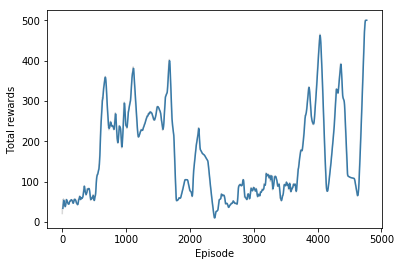

In [37]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

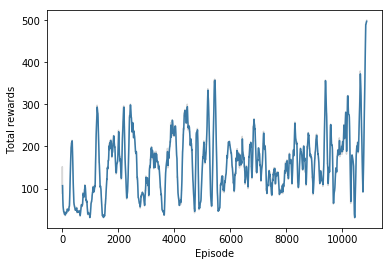

In [30]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

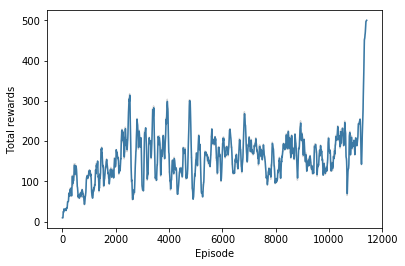

In [27]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

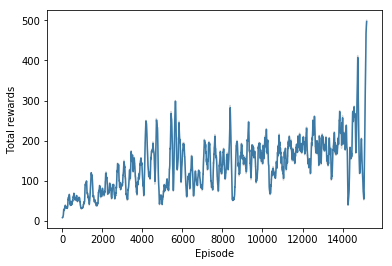

In [35]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

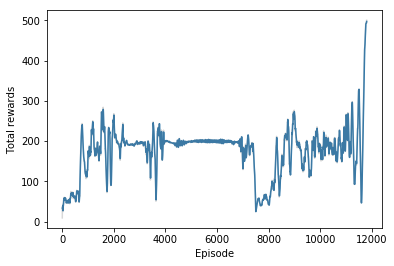

In [32]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

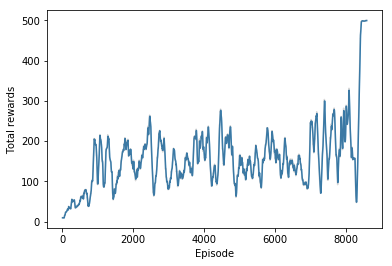

In [229]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

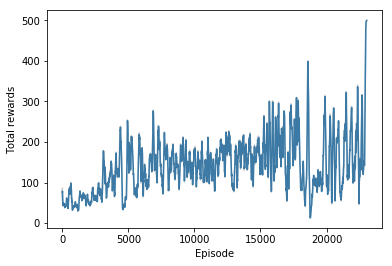

In [227]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

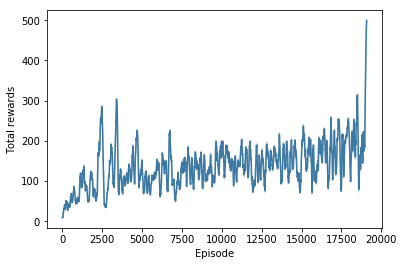

In [224]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

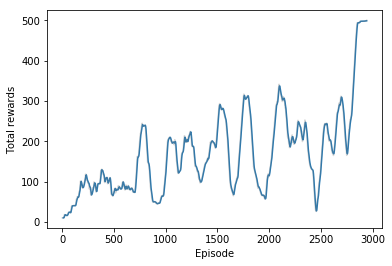

In [221]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

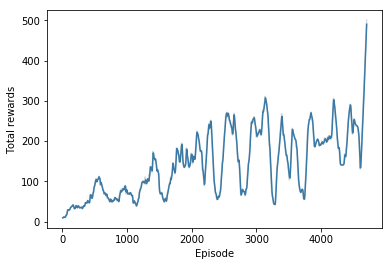

In [216]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

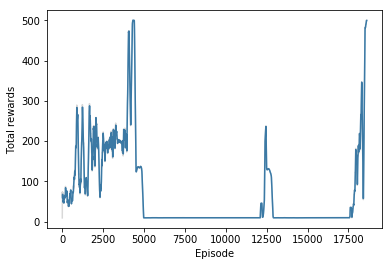

In [203]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

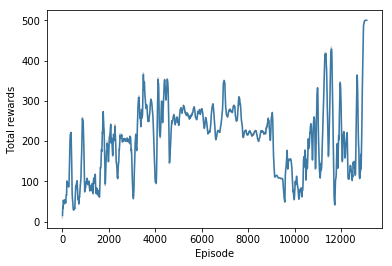

In [188]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

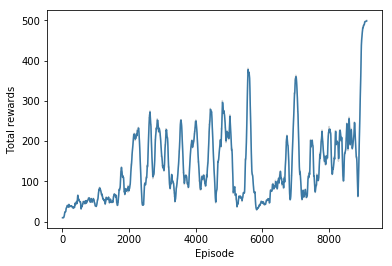

In [165]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

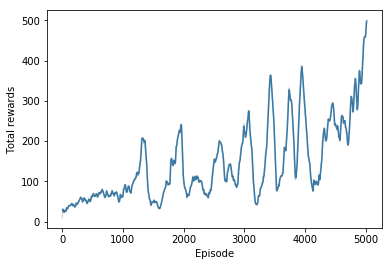

In [126]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

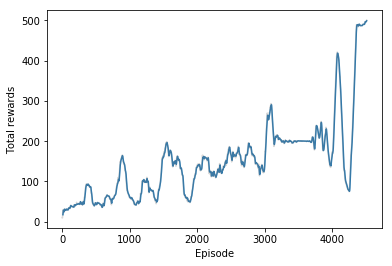

In [109]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

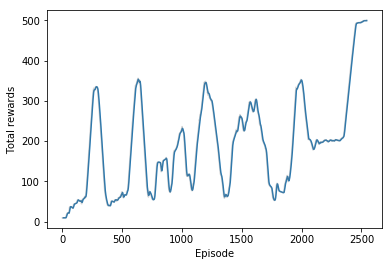

In [84]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

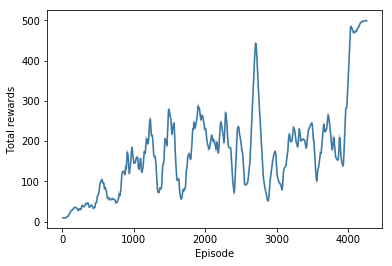

In [64]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

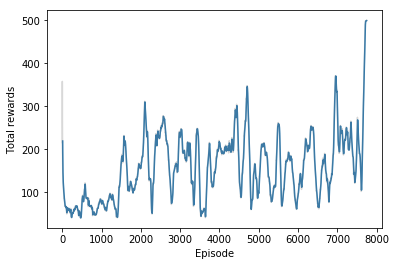

In [44]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

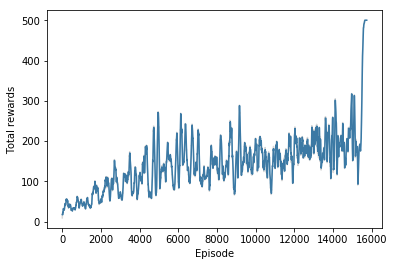

In [29]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

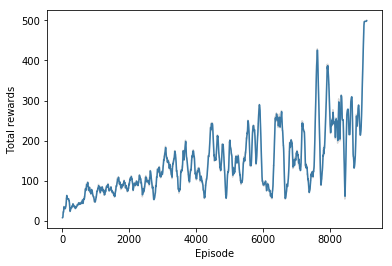

In [29]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

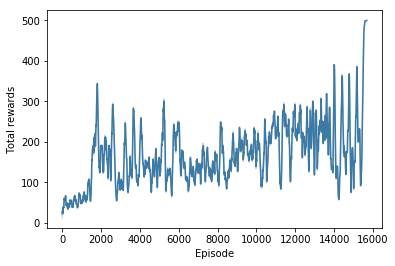

In [46]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'G losses')

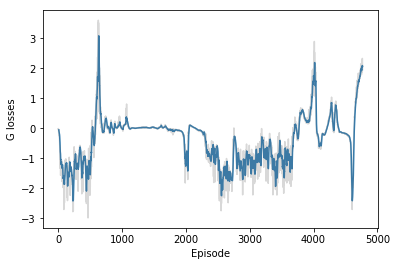

In [33]:
eps, arr = np.array(g_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('G losses')

Text(0,0.5,'G losses')

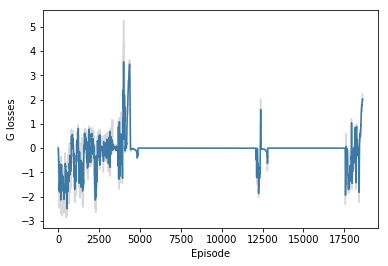

In [204]:
eps, arr = np.array(g_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('G losses')

Text(0,0.5,'D losses')

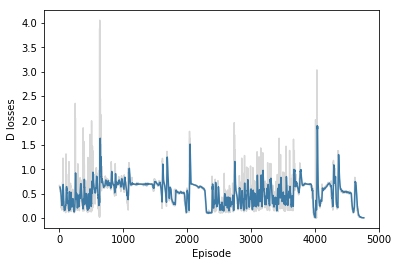

In [34]:
eps, arr = np.array(d_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses')

Text(0,0.5,'D losses R')

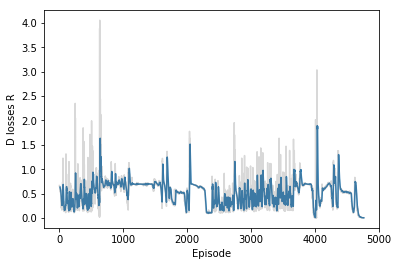

In [35]:
eps, arr = np.array(d_lossR_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses R')

Text(0,0.5,'D losses Q')

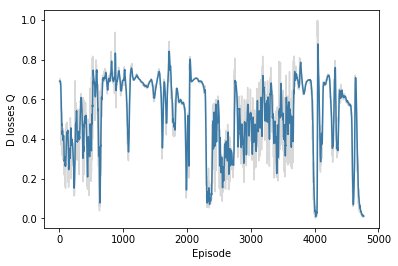

In [36]:
eps, arr = np.array(d_lossQ_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses Q')

## Testing

Let's checkout how our trained agent plays the game.

In [34]:
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Episodes/epochs
    for _ in range(100):
    #while True:
        state = env.reset()
        total_reward = 0

        # Steps/batches
        #for _ in range(111111111111111111):
        while True:
            env.render()
            action_logits = sess.run(model.actions_logits, feed_dict={model.states: np.reshape(state, [1, -1])})
            action = np.argmax(action_logits)
            state, reward, done, _ = env.step(action)
            total_reward += reward
            if done:
                break
        # Print and break condition
        print('total_reward: {}'.format(total_reward))
        # if total_reward == 500:
        #     break
                
# Closing the env
env.close()

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
INFO:tensorflow:Restoring parameters from checkpoints/model.ckpt


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0


## Extending this

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.